# M7 | Research Investigation Notebook

**Note:**

For this notebook, we chose to present our approach using a different structure than the one used for the first two research questions. While awaiting a response to [#17](https://edstem.org/eu/courses/2162/discussion/184221) regarding whether a specific template was required, we found that—for this particular research question—it was more intuitive to integrate the modeling and evaluation throughout the notebook rather than separating them into distinct sections.

In [1]:
# Core Libraries
from itertools import combinations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# Network Analysis
import networkx as nx

# Machine Learning & Clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import entropy, ttest_ind
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Time Series / Probabilistic Models
from pydtmc import MarkovChain
import pydtmc as dtmc
from tslearn.metrics import dtw

# Distance Metrics
from scipy.spatial.distance import jensenshannon

# Feature Engineering
from feature_engine.outliers import OutlierTrimmer

# Silent warnings
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = 'data'


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_e

**Research question:**
*What are the typical behavioral pathways of a student and how does it affect their learning outcomes?*

### General Approach and Summary of Key Observations

* **Data Cleaning and Preprocessing**:
  We began by preprocessing the raw dataset to remove all invalid records. Since our analysis relies heavily on student performance, we retained only activities that included a score. We also excluded activities that are not central to students’ learning paths, as well as those with unrealistic durations (too long, too short, or with invalid timestamps).

* **Duration per Activity per Student**:
  To understand how much time students spend on each activity in each course, we computed the total duration per activity per course per student. One of our first insights is that the preprocessing step significantly improved the distribution of durations, resulting in a much cleaner dataset. For consistency in later comparisons, we standardized these durations by computing their z-scores.

* **Engagement Gaps**:
  We introduced the concept of “engagement gaps,” which measures the time gaps between a student's successive activities, regardless of course or activity type.

* **Activity Transitions**:
  We analyzed each student’s pattern of transitions between (course, activity) pairs to model their learning pathways.

* **Score Normalization**:
  Instead of using raw score percentages, we applied z-score normalization within each course to allow for fair comparisons of outcomes across courses with different grading scales.

* **Consistency Filtering**:
  Through various sanity checks and visualizations, we found that not all students appeared in every one of the four derived features (durations, engagement gaps, transitions, and scores). We kept only those students present across all four dimensions to ensure consistency and completeness in downstream analyses such as clustering.

* **Distance Metric for Transition Patterns**:
  Since Markov chains of transitions can vary in state count across students, we defined a custom distance measure that combines Jensen-Shannon divergence with a penalty function. For students with similar chains, the Jensen-Shannon distance is used; for those with dissimilar or non-overlapping chains, a penalty is added.

* **Graph Construction**:
  This distance metric allowed us to build a fully connected graph of students. Even students without directly comparable chains can be assigned a distance by computing the shortest path through the graph using precomputed edge weights.

* **Clustering and Pathway Analysis**:
  With all features prepared, we proceeded to cluster the students and analyze their learning pathways. Both K-Means and Spectral Clustering methods consistently revealed two distinct clusters.

* **Cluster Interpretation**:
  Our analysis revealed that students in Cluster 1 follow a more cyclical learning path, with more loops in their activity transitions. They also tend to achieve higher grades compared to those in Cluster 0.

### Data Preprocessing Overview

We start by reading and filtering the data to retain only valid activities with associated scores. Activity durations are computed, and outliers are removed using the IQR method.

**Key Preprocessing Steps:**

We apply the following preprocessing steps to the dataset:

* Load only relevant columns from the dataframes
* Retain only users whose activities include valid score data
* Exclude activities of types *exam*, *group\_progress*, and *access*:

  * *exam* refers to simple Moodle-style PDF access and is not informative
  * *access* is always followed by a meaningful activity such as *course*, *lesson*, or *quiz*
  * *group\_progress* pertains only to teachers and is not relevant to student analysis
* Keep durations as `timedelta(ns)` to preserve precision
* Add a `durations_minutes` column for visualization and trimming
* Remove duration outliers using the IQR method and Tukey’s rules

**Outcome:**

* A cleaned `activities` DataFrame containing only relevant student activity records
* Descriptive statistics and visualizations of activity durations before and after outlier removal

In [ ]:
def preprocess_user_activity():
    """
    Load and preprocess activity data as in M4
    """
    
    activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
    all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

    activities = activities[['user_id', 'course_id', 'activity_type', 'activity_started', 'activity_completed']]
    all_scores = all_scores[['user_id', 'course', 'percentage']]

    # Keep only courses we have scores for
    activities = activities[activities['course_id'].isin(all_scores.course.unique())]
    
    # Drop irrelevant activity types
    activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]
    
    # Calculate activity durations
    activities = activities.dropna(subset=['activity_started', 'activity_completed'])
    activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
    activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
    activities['duration'] = activities['activity_completed'] - activities['activity_started']
    
    # Filter out old dates and irrelevant long durations(more than 24h long means the person might have left and finished on another day)
    activities = activities[
        (activities['duration'] >= pd.Timedelta(0)) &
        (activities['duration'] <= pd.Timedelta(hours=24)) &
        (activities['activity_started'].dt.year > 2022)
    ]
    
    # Utility column in float64 for minutes (instead of the timedelta(ns) duration)
    activities['duration_minutes'] = activities['duration'].dt.total_seconds()/60
    
    activities_before = activities.copy()
    
    # Trim outliers
    trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['duration_minutes'])
    activities = trimmer.fit_transform(activities)
        
    return activities, activities_before, all_scores

activities, activities_before, all_scores =  preprocess_user_activity()

We define mappings between `course_id` values and human-readable course names for both full and abbreviated formats to facilitate interpretation in visualizations and state modeling.
Those are the only courses we are interested in, as they are the only ones covered by the scores

In [3]:
# Print courses covered by scores
print(f"Scores cover: {all_scores.course.unique()}")

Scores cover: [  42 3865 5009 2115 5447 3301]


In [4]:
class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"

# Create mapping course_id -> course name
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

# Create mapping course_id -> short name
course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

activities_copy = activities.copy(deep=True)

### Features Creation

##### Z-Scored Durations

**Approach:**

This z-scoring allows us to compare a student’s time investment relative to peers engaging in the same type of activity within the same course.

We compute a normalized duration measure for each `(user_id, course_id, activity_type)` triplet. The steps are:

1. **Aggregate durations**: For each combination of user, course, and activity type, we compute the total time spent.
2. **Compute statistics**: For each `(course_id, activity_type)` pair, we calculate the mean and standard deviation of the aggregated durations across all users.
3. **Calculate z-score**: For each user-specific entry, we standardize the duration by subtracting the mean and dividing by the standard deviation.

**Output:**

- `zduration_sum` corresponds to the standardized duration for each user

In [5]:
def compute_zduration(df_in, user_agg='sum'):
    """
    Compute z-score normalized duration for each user per (course_id, activity_type) pair.
    """

    # Copy as to not modify the input dataframe
    df = df_in.copy(deep=True)

    # Aggregate per user per (course_id, activity_type)
    user_activity = (
        df.groupby(['user_id', 'course_id', 'activity_type'], as_index=False)
          .agg({'duration': user_agg})
    )

    # Compute mean and std per (course_id, activity_type)
    stats = (
        user_activity.groupby(['course_id', 'activity_type'])['duration']
        .agg(['mean', 'std']).reset_index()
        .rename(columns={'mean': 'mean_duration', 'std': 'std_duration'})
    )

    # Merge
    merged = user_activity.merge(stats, on=['course_id', 'activity_type'], how='left')

    # Z-score
    merged['zscore_duration'] = (merged['duration'] - merged['mean_duration']) / merged['std_duration']

    return merged[['user_id', 'course_id', 'activity_type', 'duration', 'mean_duration', 'std_duration', 'zscore_duration']]

zduration_sum = compute_zduration(activities, 'sum')
zduration_sum.head()


,user_id,course_id,activity_type,duration,mean_duration,std_duration,zscore_duration
0,1,3301,quiz,0 days 00:04:59,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.217281
1,1,3301,topic,0 days 00:00:11,0 days 01:01:16.201716738,0 days 00:56:35.367471301,-1.079471
2,1,3865,quiz,0 days 00:19:26,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.970281
3,1,3865,topic,0 days 00:56:11,0 days 01:48:34.604095563,0 days 01:46:45.686579520,-0.490752
4,1,5009,topic,0 days 03:05:13,0 days 01:26:28.571428571,0 days 01:28:26.502501462,1.116447


##### Engagement Gaps

**Approach:**

Track engagement by computing the gaps in days between each user's activities (we compute the number of days between each user's active sessions to analyze engagement gaps).

- For each user, compute the sequence of day-to-day gaps between unique activity dates.
- Store sorted lists of these gaps as a measure of consistency

**Outcome:**
- `gap_days` contains for each user_id an ordered list of the amount of days elapsed between actions

In [6]:
user_daily_activity = activities.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevant columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Ceate a csv of user_ids, gap_days where gap_days is a list of the gaps (ignore nans) in increasing order. Use copies of the dataframes
gap_days = user_daily_activity.copy(deep=True)[['user_id', 'gap_days']]
# Remove the first gap_days (nan) for each user
gap_days.dropna(subset=['gap_days'], inplace=True)
# Group by user_id and aggregate the gap_days into a list
gap_days = gap_days.groupby('user_id')['gap_days'].apply(lambda x: list(x)).reset_index()
# Sort the gap_days list for each user
gap_days['gap_days'] = gap_days['gap_days'].apply(lambda x: sorted(x))

# Display
gap_days.head()

,user_id,gap_days
0,1,"[1.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 19.0,..."
1,4,"[2.0, 6.0, 7.0, 8.0, 13.0, 51.0]"
2,6,"[2.0, 2.0, 6.0, 6.0, 8.0, 14.0, 20.0, 44.0]"
3,7,"[1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, ..."
4,9,"[2.0, 7.0, 8.0, 12.0, 18.0, 24.0, 25.0]"


##### Learning Pathway Modeling


**Approach:**

To capture the behavioral pathways of each student, we model their activity sequences using Markov Chains. This allows us to represent transitions between learning activities as probabilistic state changes.

- **Define states**: Each activity is represented as an `activity_state`, defined as a tuple `(activity_type, course_id)`.
- **Index mapping**: All unique `activity_state` values are mapped to numeric indices for efficient processing.
- **Extract transitions**: We sort each user's activities chronologically and record transitions from one state to the next.
- **Build transition matrices**: For each user, a transition matrix is created based on the observed state changes.
- **Prune unused states**: States with no transitions are either removed or made absorbing to ensure valid chain construction.
- **Construct Markov Chains**: Each user’s transition matrix is converted into a `MarkovChain` object using the `pydtmc` library and stored in the `user_chains` dictionary.

This model serves as a compact representation of each student’s learning journey on the platform.

**Output:**

Each MarkovChain's states are pairs of `activity_type` and `course_id` (we call them `activity_state`) with transition probabilities to each other and themselves.

We index them via dictionary `state_to_idx` (whose inverse is dictionary `idx_to_state`), shift in order to get `next_state_idx`, calculate transition matrices, prune unvisited states and finally initialize the dictionary.

In [7]:
# Copy dataset
transitions = activities.copy()
transitions.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

# Build activity_state = (activity_type, course_id) and log durations where possible
transitions['activity_state'] = transitions['activity_type'] + '_' + transitions['course_id'].map(course_map_short).fillna('Unknown')

# Index states numerically
state_to_idx = {s: i for i, s in enumerate(transitions['activity_state'].unique())}
transitions['state_idx'] = transitions['activity_state'].map(state_to_idx)

# Log subsequent states into a separate column
transitions['next_state_idx'] = transitions.groupby('user_id')['state_idx'].shift(-1)
transitions = transitions.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)

# Create a list of all unique states and their indices
all_states = transitions['activity_state'].unique().tolist()
n_states = len(all_states)

# Keep only relevant columns for transitions
final_transitions = transitions[['user_id', 'activity_state', 'state_idx', 'next_state_idx']]
final_transitions.head()

,user_id,activity_state,state_idx,next_state_idx
36137,1,quiz_KZG_E,0,1
45192,1,topic_KZG_TC,1,1
45206,1,topic_KZG_TC,1,1
46437,1,topic_KZG_TC,1,1
47334,1,topic_KZG_TC,1,1


There shouldn't actually be any _Unknown_ thanks to preprocessing, verify it:

In [8]:
# Assert there is no Unknown state
assert 'Unknown' not in final_transitions['activity_state'].unique()
print(final_transitions['activity_state'].unique())

['quiz_KZG_E' 'topic_KZG_TC' 'topic_KZG_E' 'topic_KZG_M' 'quiz_KZG_M'
 'topic_LZG_M' 'quiz_LZG_M' 'lesson_LZG_TC' 'topic_LZG_TC' 'lesson_LZG_E'
 'topic_LZG_E' 'quiz_LZG_E' 'lesson_KZG_M' 'lesson_KZG_E' 'lesson_LZG_M'
 'lesson_KZG_TC']


We now need to prune the user matrices to include only the states between which actual transitions occur.

In [10]:
# Mapping dictionary for state indices
idx_to_state = {i: name for name, i in state_to_idx.items()}

# Total number of possible states
n_states = max(
    final_transitions['state_idx'].max(),
    final_transitions['next_state_idx'].max()
) + 1

def compute_pruned(df):
    # Build full count‐matrix
    counts = pd.crosstab(df['state_idx'], df['next_state_idx'])
    counts = counts.reindex(
        index=range(n_states),
        columns=range(n_states),
        fill_value=0
    )

    # Pick any state that appears as from‐state OR to‐state
    used = (counts.sum(axis=1) > 0) | (counts.sum(axis=0) > 0)
    used_states = counts.index[used]     # these are the original idxs we keep

    # Prune to only those
    pruned = counts.loc[used_states, used_states].copy()

    # Make any zero‐row into an absorbing self‐loop
    zero_rows = pruned.sum(axis=1) == 0
    for s in zero_rows[zero_rows].index:
        pruned.at[s, s] = 1

    # Normalize each row
    P = pruned.div(pruned.sum(axis=1), axis=0)
    return P

# Apply per user
user_pruned_matrices = {
    uid: compute_pruned(g)
    for uid, g in final_transitions.groupby('user_id')
}

**Sanity Check:**

User 18 should have only the following transitions:

* 10 → 10 occurring 3 times (75%)
* 10 → 11 occurring once (25%)


In [11]:
P_example = user_pruned_matrices[18]
print(P_example)

state_idx    10    11
state_idx            
10         0.75  0.25
11         0.00  1.00


### Markov Chain Creation for Each Student (Clustering Input)

In [13]:
# Create Makov Chains for each user
user_chains = {}

for uid in user_pruned_matrices:
    pruned_matrix = user_pruned_matrices[uid]
    if pruned_matrix.shape[0]>1:
        user_chains[uid] = MarkovChain(pruned_matrix, [idx_to_state[i] for i in pruned_matrix.index.tolist()])
    else:
        user_chains.pop(uid, None)

print(MarkovChain(user_pruned_matrices[18], [idx_to_state[i] for i in user_pruned_matrices[18].index.tolist()]))


DISCRETE-TIME MARKOV CHAIN
 SIZE:           2
 RANK:           2
 CLASSES:        2
  > RECURRENT:   1
  > TRANSIENT:   1
 ERGODIC:        NO
  > APERIODIC:   YES
  > IRREDUCIBLE: NO
 ABSORBING:      YES
 MONOTONE:       YES
 REGULAR:        NO
 REVERSIBLE:     YES
 SYMMETRIC:      NO



Let’s display the median and mean duration per `activity_type` for each `course`.

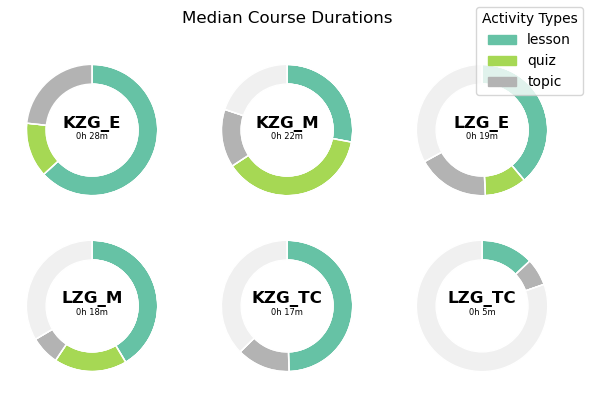

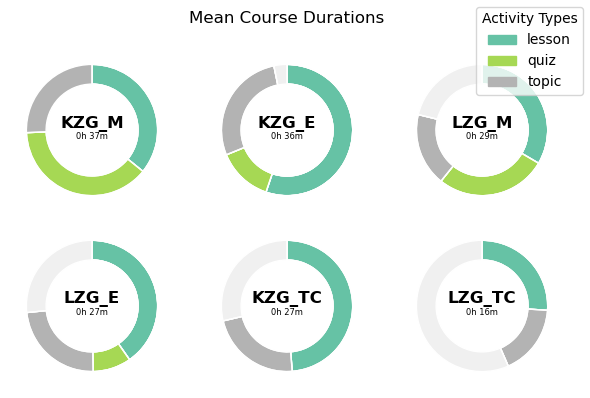

In [14]:
def plot_course_durations(df_median, course_map_short, title):
    # Prepare the data
    df_median = df_median.copy()
    df_median['duration_sec'] = df_median['duration'].dt.total_seconds()
    
    total_durations = df_median.groupby('course_id')['duration_sec'].sum()
    max_total_duration = total_durations.max()

    # Color map for activities
    activity_types = sorted(df_median['activity_type'].unique())
    cmap = plt.get_cmap('Set2')
    colors = cmap(np.linspace(0, 1, len(activity_types)))
    color_map = dict(zip(activity_types, colors))

    # Plot settings
    courses = total_durations.sort_values(ascending=False).index
    n_courses = len(courses)
    n_cols = 3
    n_rows = int(np.ceil(n_courses / n_cols))
    scale = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale))
    axes = axes.flatten()

    for idx, course_id in enumerate(courses):
        ax = axes[idx]
        course_data = df_median[df_median['course_id'] == course_id]
        durations = course_data['duration_sec'].values
        labels = course_data['activity_type'].values

        total_duration = durations.sum()
        course_fraction = total_duration / max_total_duration
        max_angle = 360 * course_fraction  # Total filled angle for this course

        # Compute sizes in angles instead of fractions of 1
        sizes = durations / total_duration * max_angle

        start_angle = 90
        for label, size in zip(labels, sizes):
            ax.pie(
                [size, 360 - size], 
                colors=[color_map[label], (0, 0, 0, 0)],  # Transparent for remaining part
                startangle=start_angle, 
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )
            start_angle -= size

        # Draw the remaining transparent gap (optional light gray)
        if course_fraction < 1:
            ax.pie(
                [360 * (1 - course_fraction), 360 * course_fraction],
                colors=['#f0f0f0', (0, 0, 0, 0)],
                startangle=90 - max_angle,
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )

        # Add center text
        course_name = course_map_short.get(course_id, course_id)
        total_hours = int(total_duration // 3600)
        total_minutes = int((total_duration % 3600) // 60)
        ax.text(0, 0.1, course_name, ha='center', va='center', fontsize=12, weight='bold')
        ax.text(0, -0.1, f"{total_hours}h {total_minutes}m", ha='center', va='center', fontsize=6)
        
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    # Add Legend
    legend_patches = [mpatches.Patch(color=color_map[act], label=act) for act in activity_types]
    fig.legend(
        handles=legend_patches,
        fontsize=10, 
        loc='upper right', 
        title='Activity Types'
    )
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Median durations
course_median_duration = activities.groupby(['course_id', 'activity_type'])['duration'].median().reset_index()
plot_course_durations(course_median_duration, course_map_short, title="Median Course Durations")

# Mean durations
course_mean_duration = activities.groupby(['course_id', 'activity_type'])['duration'].mean().reset_index()
plot_course_durations(course_mean_duration, course_map_short, title="Mean Course Durations")

### Student Scores (Target):

We use z-scoring on scores per course to obtain normalized scores


In [15]:
df = all_scores.copy()
df["zscore"] = df.groupby("course")["percentage"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
zscores = df.rename(columns={'course': 'course_id'})
zscores.describe()

,user_id,course_id,percentage,zscore
count,6432.000000,6432.000000,6432.000000,6.432000e+03
mean,2420.168999,2894.153141,56.098510,-1.115747e-16
std,1698.985735,2011.163854,29.366960,1.000078e+00
min,1.000000,42.000000,0.000000,-5.423334e+00
25%,332.000000,42.000000,36.099727,-6.343278e-01
50%,3503.000000,3865.000000,62.500000,2.908645e-02
75%,3932.000000,3865.000000,78.000000,7.789549e-01
max,4095.000000,5447.000000,100.000000,3.370601e+00


### Restrict to Users in the Intersection Only

To ensure consistency, we only retain users who are present in all components:

- `zduration_sum`: Normalized activity durations.
- `gap_days`: Engagement gap lists.
- `user_chains`: Individual Markov Chain objects.
- `zscores`: Target variable for performance.

This ensures that clustering uses complete and coherent feature representations.

In [16]:
zduration_users = set(zduration_sum['user_id'])
gap_days_users = set(gap_days['user_id'])
user_chains_users = set(user_chains.keys())
zscores_users = set(zscores['user_id'])

# Find the intersection
common_users = zduration_users & gap_days_users & user_chains_users & zscores_users

# Filter each dataframe/dict to only the common users
zduration_sum = zduration_sum[zduration_sum['user_id'].isin(common_users)]
gap_days = gap_days[gap_days['user_id'].isin(common_users)]
user_chains = {k: v for k, v in user_chains.items() if k in common_users}
zscores = zscores[zscores['user_id'].isin(common_users)]

common_users = sorted(common_users)

# Print the number of users in the intersection
print(f'Number of users in all four: {len(common_users)}')

Number of users in all four: 501


### Distance Metric Based on Students' Markov Models

**Approach:**

Let's define a distance between users by comparing their Markov chains. It combines **Jensen-Shannon divergence** over shared states (for transition similarity) and a **penalty** for having different state sets:

$$
\text{Distance} = \alpha \cdot \text{JS} + (1 - \alpha) \cdot \left(1 - \frac{|\text{common states}|}{|\text{all states}|}\right)
$$

In [30]:
def compute_js_with_penalty(c1, c2, alpha=0.5, pen_multiplier=1):
    """Compute JS divergence + penalty between two Markov chains."""
    
    # Common states between the two chains
    common = list(set(c1.states) & set(c2.states))
    if len(common) < 2:
        return None  # Not enough overlap to compare

    # Indices of common states in each chain
    idx1 = [c1.states.index(s) for s in common]
    idx2 = [c2.states.index(s) for s in common]

    # Submatrices of common states
    P = c1.p[np.ix_(idx1, idx1)]
    Q = c2.p[np.ix_(idx2, idx2)]

    # Average JS divergence for matching rows
    js_vals = []
    for p, q in zip(P, Q):
        if p.sum() > 0 and q.sum() > 0:
            js_vals.append(jensenshannon(p / p.sum(), q / q.sum(), base=2))

    if not js_vals:
        return None

    js = np.mean(js_vals)

    # Penalty for non-overlapping states
    penalty = 1 - len(common) / len(set(c1.states) | set(c2.states))

    # Return weighted sum of JS and penalty
    return alpha * js + (1 - alpha) * penalty * pen_multiplier


def build_distance_matrix(user_chains, alpha=0.5, pen_multiplier=1):
    """Build a distance matrix between users based on their Markov chains."""
    
    users = list(user_chains.keys())

    # Initialize direct distances (0 for same user, inf otherwise)
    direct = { (u,v): (0.0 if u==v else float('inf')) for u in users for v in users }

    # Compute pairwise distances using JS + penalty
    for u1, u2 in combinations(users, 2):
        dist = compute_js_with_penalty(user_chains[u1], user_chains[u2],
                                       alpha=alpha, pen_multiplier=pen_multiplier)
        if dist is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = dist

    # Build graph with finite distances as weighted edges
    G = nx.Graph()
    G.add_nodes_from(users)
    for (u,v), w in direct.items():
        if u != v and w < float('inf'):
            G.add_edge(u, v, weight=w)

    # Compute shortest path distances between all users
    sp_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    # Fill distance matrix using shortest path distances
    D = pd.DataFrame(float('inf'), index=users, columns=users)
    for u in users:
        for v, d in sp_lengths[u].items():
            D.at[u, v] = d

    # Number of connected components in the graph
    n_components = nx.number_connected_components(G)

    return D, n_components

# Compute the distance matrix and number of user groups (connected components)
dist_matrix, components = build_distance_matrix(user_chains, alpha=0.2, pen_multiplier=1)
print("Connected components:", components)

Connected components: 1


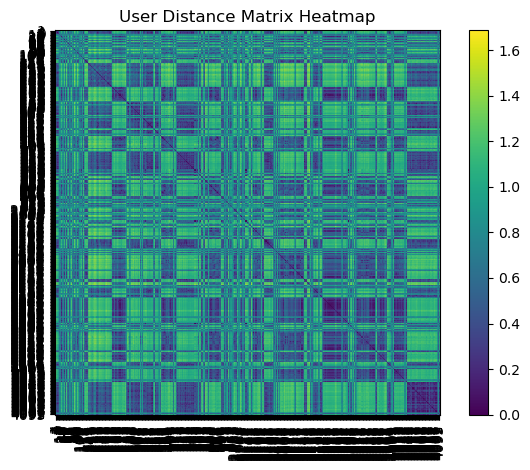

In [31]:
# Display the distance matrix as Heatmap
fig, ax = plt.subplots()
im = ax.imshow(dist_matrix.values)

# Label axes with user IDs
ax.set_xticks(range(len(dist_matrix.columns)))
ax.set_xticklabels(dist_matrix.columns, rotation=90)
ax.set_yticks(range(len(dist_matrix.index)))
ax.set_yticklabels(dist_matrix.index)

ax.set_title('User Distance Matrix Heatmap')

# Add a colorbar to interpret distances
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

Finally, let's computes a combined distance matrix between users by integrating three distance metrics:

- DTW distance based on users’ activity gap sequences
- Graph-based distance derived from the shortest paths in the Markov-based user graph
- Direct Markov-based distance

In [32]:
# DTW Distance Matrix based on gap_days
n_users = len(common_users)
graph_matrix = dist_matrix.values
gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()
gap_days_seqs = [gap_days_map[u] for u in common_users]
dtw_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        d = dtw(gap_days_seqs[i], gap_days_seqs[j])
        dtw_matrix[i, j] = dtw_matrix[j, i] = d

def normalize_matrix(m):
    """Normalize matrix"""
    return (m - np.min(m)) / (np.max(m) - np.min(m))

dtw_norm = normalize_matrix(dtw_matrix)
graph_norm = normalize_matrix(graph_matrix)
combined_matrix = (dtw_norm + 2*dist_matrix + graph_norm) / 4.0

### Visualization Illustrating the Theory Behind the Metric

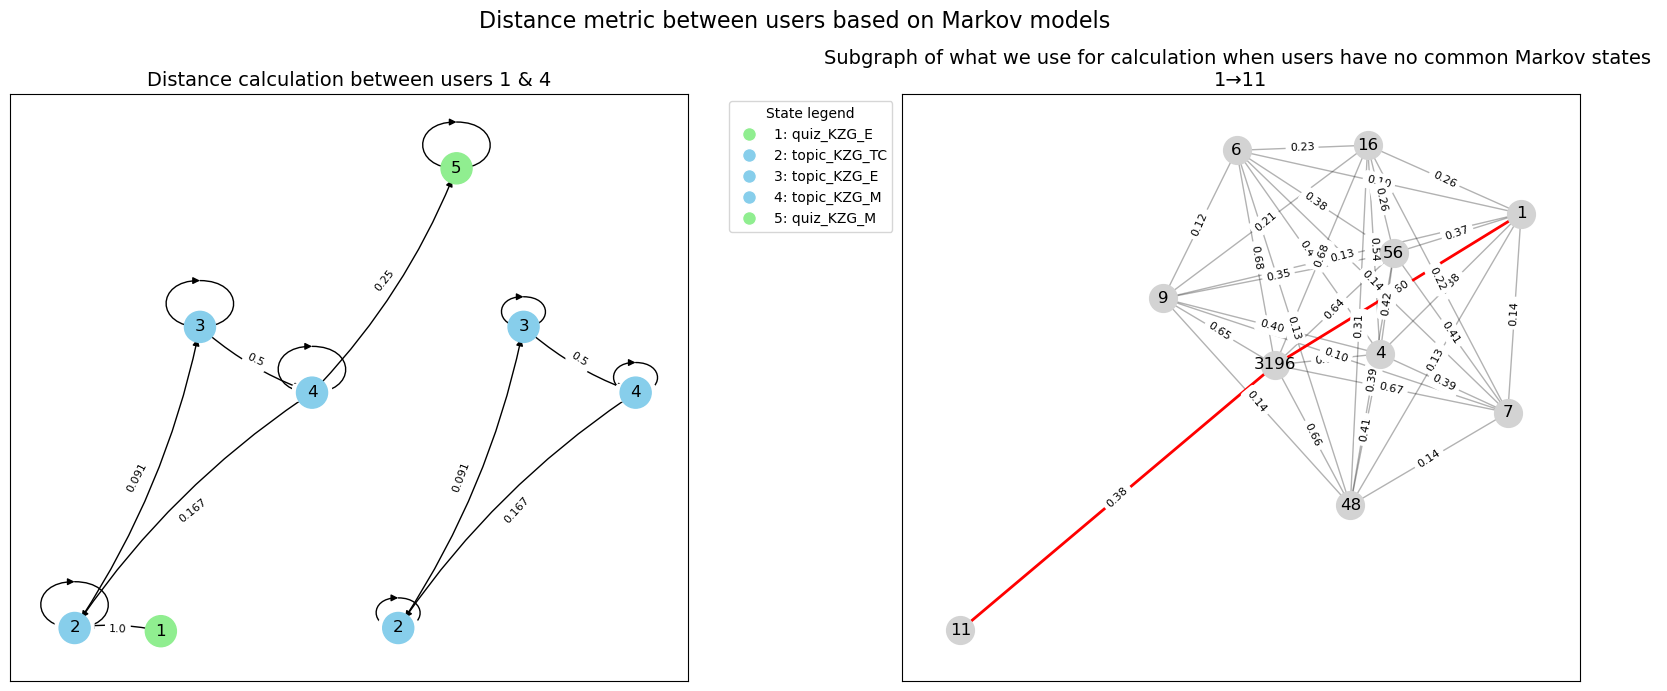

In [34]:
def build_distance_graph(user_chains, alpha=0.5, pen_multiplier=1):
    """Builds a graph from pairwise distances, skipping pairs with no overlap."""
    users = list(user_chains.keys())
    direct = {(u,v): (0.0 if u == v else float('inf')) for u in users for v in users}

    for u1, u2 in combinations(users, 2):
        dist = compute_js_with_penalty(user_chains[u1], user_chains[u2], alpha=alpha, pen_multiplier=pen_multiplier)
        if dist is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = dist

    G = nx.Graph()
    G.add_nodes_from(users)
    for (u, v), w in direct.items():
        if u != v and w < float('inf'):
            G.add_edge(u, v, weight=w)

    return G, direct

# Helper function
def expand_to_n_nodes(G, core_nodes, n=10):
    included = set(core_nodes)
    queue = list(core_nodes)
    while queue and len(included)<n:
        v = queue.pop(0)
        for nbr in G.neighbors(v):
            if nbr not in included:
                included.add(nbr)
                queue.append(nbr)
                if len(included)>=n:
                    break
    return included

# 
def plot_two_panels(user_chains, alpha=0.2, pen_mult=1):
    """Display two panels as figure"""

    # Pick one pair WITH common states
    users = list(user_chains.keys())
    s1, s2 = next((a,b) for a,b in combinations(users,2) if set(user_chains[a].states) & set(user_chains[b].states))
    c1, c2 = user_chains[s1], user_chains[s2]

    # Build distance graph, pick pair WITHOUT common 
    G, direct = build_distance_graph(user_chains, alpha, pen_mult)
    a,b = next((u,v) for u,v in combinations(users,2) if direct[(u,v)]>=float('inf') and v in nx.node_connected_component(G,u))
    path = nx.shortest_path(G, a, b, weight='weight')

    # 10-node neighborhood around that path
    nodes10 = expand_to_n_nodes(G, path, n=10)
    subG10  = G.subgraph(nodes10).copy()

    # Union graph of the two chains
    H = nx.DiGraph()
    for C in (c1, c2):
        for i,u in enumerate(C.states):
            for j,v in enumerate(C.states):
                if C.p[i,j]>0:
                    H.add_edge(u,v, weight=round(C.p[i,j],3))

    # build a single layout, then split
    pos0 = nx.spring_layout(H, seed=42)
    pos1 = {n:(x*0.4-0.3,y) for n,(x,y) in pos0.items()}
    pos2 = {n:(x*0.4+0.3,y) for n,(x,y) in pos0.items()}

    # Classify states
    common = set(c1.states) & set(c2.states)
    unique = set(c1.states)-common
    def node_color(s):
        if s in common:   return 'skyblue'
        if s in unique:  return 'lightgreen'
        return 'lightcoral'

    # Remap state names -> small ints for left panel
    left_states = list(c1.states) + [s for s in c2.states if s not in c1.states]
    left_states = list(dict.fromkeys(left_states))
    mapping = {state: idx+1 for idx, state in enumerate(left_states)}

    # Display plots
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
    fig.suptitle("Distance metric between users based on Markov models", fontsize=16)

    # Left panel
    for states,pos in [(c1.states,pos1),(c2.states,pos2)]:
        # nodes with numeric labels
        nx.draw_networkx_nodes(H.subgraph(states), pos,
                               node_color=[node_color(s) for s in states],
                               node_size=500, ax=ax1)
        # edges
        nx.draw_networkx_edges(H.subgraph(states), pos,
                               arrows=True, arrowstyle='-|>',
                               ax=ax1, connectionstyle='arc3,rad=0.1')
        # numeric labels
        labels_num = {s: str(mapping[s]) for s in states}
        nx.draw_networkx_labels(H.subgraph(states), pos,
                                labels=labels_num, ax=ax1)
        # edge-labels = transition probs
        edge_lbls = nx.get_edge_attributes(H.subgraph(states),'weight')
        nx.draw_networkx_edge_labels(H.subgraph(states), pos,
                                     edge_labels=edge_lbls,
                                     font_size=8, ax=ax1)

    ax1.set_title(f"Distance calculation between users {s1} & {s2}", fontsize=14)
    # legend at right of left plot
    legend_items = [plt.Line2D([0],[0], marker='o', color='w',
                     label=f"{mapping[state]}: {state}",
                     markerfacecolor=node_color(state), markersize=10)
                    for state in left_states]
    ax1.legend(handles=legend_items, bbox_to_anchor=(1.05,1), loc='upper left', title="State legend")

    # Right panel
    posR = nx.spring_layout(subG10, seed=24)

    # Nodes
    nx.draw_networkx_nodes(subG10, posR, node_color='lightgray', node_size=400, ax=ax2)
    nx.draw_networkx_labels(subG10, posR, ax=ax2)

    # All edges lightly
    nx.draw_networkx_edges(subG10, posR, ax=ax2, alpha=0.3)

    # Highlight the shortest-path edges in red
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(subG10, posR, edgelist=path_edges, edge_color='r', width=2, ax=ax2)

    # Draw edge weight labels on top of edges
    wlabels = nx.get_edge_attributes(subG10, 'weight')
    wlabels_2d = {k: f"{v:.2f}" for k, v in wlabels.items()}
    nx.draw_networkx_edge_labels(subG10, posR, edge_labels=wlabels_2d, font_size=8, ax=ax2)
    ax2.set_title(f"Subgraph of what we use for calculation when users have no common Markov states \n{a}→{b}", fontsize=14)

    plt.tight_layout()
    plt.show()

plot_two_panels(user_chains, alpha=0.2, pen_mult=1)

### Students Clustering

**Approach:**

We will apply two clustering methods: K-Means and Spectral Clustering, and compare their results.

To determine the optimal number of clusters for each method, we will use the silhouette score.


Best Spectral Clustering: 2 clusters (Silhouette = 0.616)
Best KMeans Clustering: 2 clusters (Silhouette = 0.616)


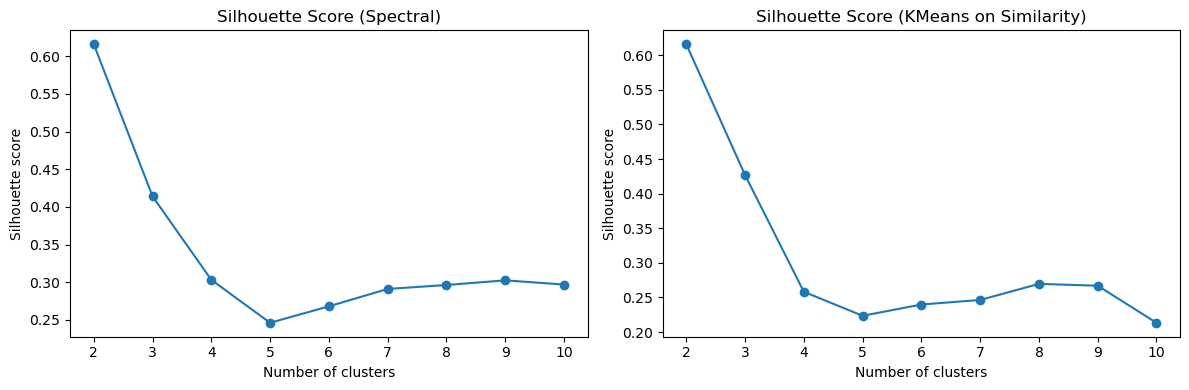

In [35]:
# Convert distance matrix to similarity matrix
sigma = np.median(combined_matrix)
similarity_matrix = np.exp(-combined_matrix ** 2 / (2.0 * sigma ** 2))

range_n_clusters = range(2, min(11, len(common_users)))

# Initialize tracking variables
results = {
    'Spectral': {'scores': [], 'best_score': -1, 'best_n': None, 'best_labels': None},
    'KMeans': {'scores': [], 'best_score': -1, 'best_n': None, 'best_labels': None}
}

# Run both clustering methods for each k
for n_clusters in range_n_clusters:
    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels_spec = spectral.fit_predict(similarity_matrix)
    score_spec = silhouette_score(combined_matrix, labels_spec, metric='precomputed')
    results['Spectral']['scores'].append(score_spec)
    if score_spec > results['Spectral']['best_score']:
        results['Spectral'].update({'best_score': score_spec, 'best_n': n_clusters, 'best_labels': labels_spec})
    
    # KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_km = kmeans.fit_predict(similarity_matrix)
    score_km = silhouette_score(combined_matrix, labels_km, metric='precomputed')
    results['KMeans']['scores'].append(score_km)
    if score_km > results['KMeans']['best_score']:
        results['KMeans'].update({'best_score': score_km, 'best_n': n_clusters, 'best_labels': labels_km})

# Print best results
print(f"Best Spectral Clustering: {results['Spectral']['best_n']} clusters (Silhouette = {results['Spectral']['best_score']:.3f})")
print(f"Best KMeans Clustering: {results['KMeans']['best_n']} clusters (Silhouette = {results['KMeans']['best_score']:.3f})")

# Plot both silhouette curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(list(range_n_clusters), results['Spectral']['scores'], marker='o')
axs[0].set_title("Silhouette Score (Spectral)")
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("Silhouette score")

axs[1].plot(list(range_n_clusters), results['KMeans']['scores'], marker='o')
axs[1].set_title("Silhouette Score (KMeans on Similarity)")
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Silhouette score")

plt.tight_layout()
plt.show()

# Save best labels
labels_spectral = results['Spectral']['best_labels']
labels_kmeans = results['KMeans']['best_labels']

# Cluster information
cluster_df = pd.DataFrame({
    'user_id': common_users,
    'cluster_spectral': labels_spectral,
    'cluster_kmeans': labels_kmeans
})

**Observation:**

Both clustering methods identify an optimal number of clusters at `k = 2`, yielding the same silhouette score of 0.616. However, as `k` increases, the silhouette scores diverge. This suggests that with two clusters, the methods may capture a similar underlying structure, while with more clusters, they begin to detect different patterns. Let's now compare the agreement between the two methods.


In [36]:
# Compute agreement between Spectral and K-means
ari = adjusted_rand_score(labels_kmeans, labels_spectral)
nmi = normalized_mutual_info_score(labels_kmeans, labels_spectral)

print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")


Adjusted Rand Index (ARI): 1.00
Normalized Mutual Information (NMI): 1.00


**Observation:**

Both the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) between K-means and Spectral Clustering cluster assignments are 1.0, indicating perfect agreement between the two methods for this choice of features and cluster number. This strong consistency suggests that the features may capture a robust underlying structure in the data that is recognized by both algorithms.

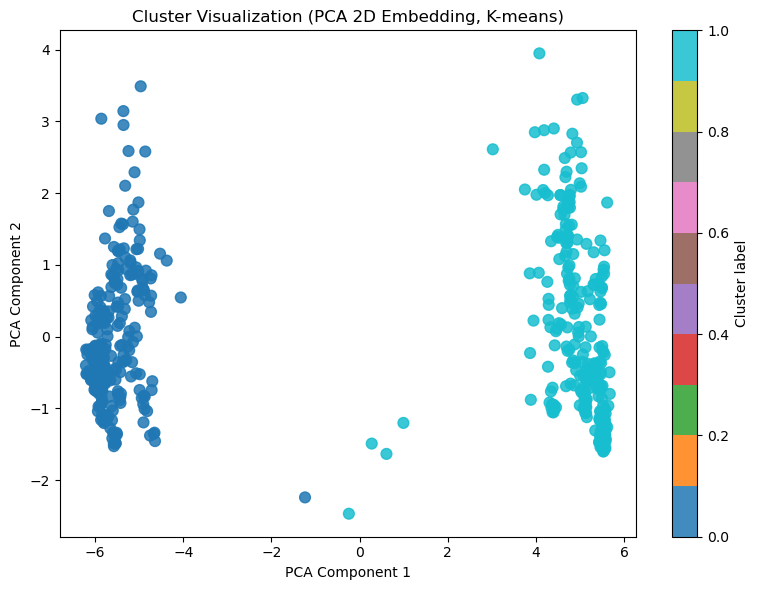

In [37]:
# PCA projection to 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(combined_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels_kmeans, cmap='tab10', s=60, alpha=0.85)
plt.title('Cluster Visualization (PCA 2D Embedding, K-means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster label')
plt.tight_layout()
plt.show()

**Observation:**

The PCA projection reveals two clearly separated clusters in 2D. Our assumption is the original high-dimensional space, some intra-cluster variability or borderline cases lower the silhouette score.

### Clusters Structural Difference

Now that we have our clusters, let's analyze how students' Markov chain structures differ. For example, whether one cluster has more nodes, edges, or cycles than the other.


In [40]:
def markov_chain_metrics(chain):
    n_states = len(chain.states)
    n_transitions = np.sum(chain.p > 0)

    # Loop ratio = fraction of states with a self-loop
    self_loops = np.sum(np.diag(chain.p) > 0)
    loop_ratio = self_loops / n_states if n_states > 0 else 0

    # Cycle ratio = fraction of transitions involved in non-trivial cycles
    G = nx.DiGraph()
    for i, u in enumerate(chain.states):
        for j, v in enumerate(chain.states):
            if chain.p[i, j] > 0:
                G.add_edge(u, v)
    cycles = list(nx.simple_cycles(G))
    non_trivial_cycles = [c for c in cycles if len(c) > 1]
    transitions_in_cycles = set()
    for cycle in non_trivial_cycles:
        transitions_in_cycles.update((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle)))
    cycle_ratio = len(transitions_in_cycles) / n_transitions if n_transitions > 0 else 0

    try:
        stat_dist = chain.steady_state_distribution
        stat_entropy = entropy(stat_dist)
    except Exception:
        stat_entropy = np.nan

    return n_states, n_transitions, loop_ratio, cycle_ratio, stat_entropy


metrics = []
for uid in common_users:
    chain = user_chains[uid]
    n_states, n_trans, loop_ratio, cycle_ratio, stat_entropy = markov_chain_metrics(chain)
    metrics.append({
        'user_id': uid,
        'n_states': n_states,
        'n_transitions': n_trans,
        'loop_ratio': loop_ratio,
        'cycle_ratio': cycle_ratio,
        'stat_entropy': stat_entropy,
    })

metrics_df = pd.DataFrame(metrics)
metrics_df['cluster'] = labels_kmeans

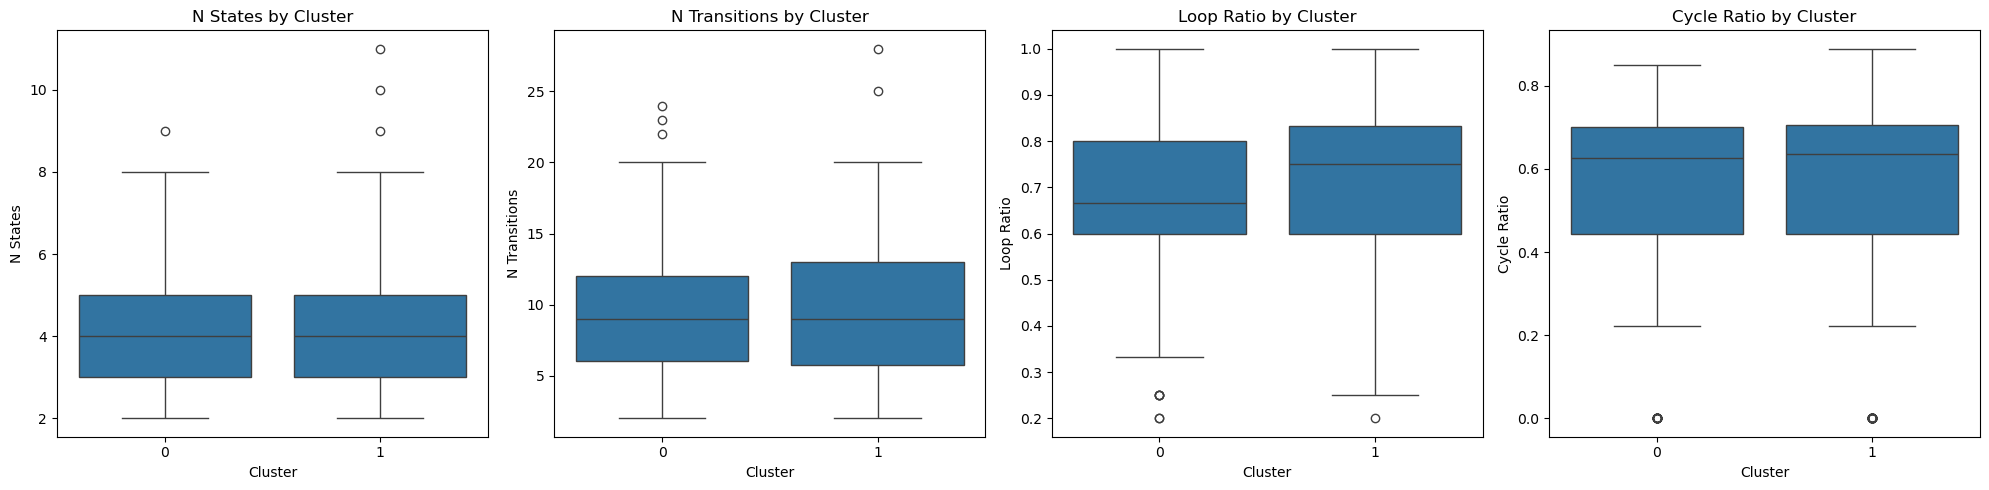

In [45]:
metrics_to_plot = ['n_states', 'n_transitions', 'loop_ratio', 'cycle_ratio']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(metrics_to_plot):
    sns.boxplot(data=metrics_df, x='cluster', y=metric, ax=axes[i])
    axes[i].set_title(f"{metric.replace('_', ' ').title()} by Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()


In [48]:
# Print median loop ratio per cluster
loop_cycle_stats = metrics_df.groupby('cluster')[['loop_ratio']].median()
print("Median Loop Ratio per Cluster:")
print(loop_cycle_stats)

Median Loop Ratio per Cluster:
         loop_ratio
cluster            
0          0.666667
1          0.750000


**Observation:**

We observe more looping behavior in Cluster 1 (loop ratio 0.75 vs 0.67), suggesting a more repetitive learning style.

# M7 | Research Investigation Notebook

**Note:**

For this notebook, we chose to present our approach using a different structure than the one used for the first two research questions. While awaiting a response to [#17](https://edstem.org/eu/courses/2162/discussion/184221) regarding whether a specific template was required, we found that—for this particular research question—it was more intuitive to integrate the modeling and evaluation throughout the notebook rather than separating them into distinct sections.

In [ ]:
# Core Libraries
from itertools import combinations
import numpy as np
import pandas as pd

# Visualization
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

# Network Analysis
import networkx as nx

# Machine Learning & Clustering
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import entropy, ttest_ind
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Time Series / Probabilistic Models
from pydtmc import MarkovChain
import pydtmc as dtmc
from tslearn.metrics import dtw

# Distance Metrics
from scipy.spatial.distance import jensenshannon

# Feature Engineering
from feature_engine.outliers import OutlierTrimmer

# Silent warnings
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = 'data'


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/iliasmerigh/opt/miniconda3/envs/mlbehavior_e

**Research question:**
*What are the typical behavioral pathways of a student and how does it affect their learning outcomes?*

### General Approach and Summary of Key Observations

* **Data Cleaning and Preprocessing**:
  We began by preprocessing the raw dataset to remove all invalid records. Since our analysis relies heavily on student performance, we retained only activities that included a score. We also excluded activities that are not central to students’ learning paths, as well as those with unrealistic durations (too long, too short, or with invalid timestamps).

* **Duration per Activity per Student**:
  To understand how much time students spend on each activity in each course, we computed the total duration per activity per course per student. One of our first insights is that the preprocessing step significantly improved the distribution of durations, resulting in a much cleaner dataset. For consistency in later comparisons, we standardized these durations by computing their z-scores.

* **Engagement Gaps**:
  We introduced the concept of “engagement gaps,” which measures the time gaps between a student's successive activities, regardless of course or activity type.

* **Activity Transitions**:
  We analyzed each student’s pattern of transitions between (course, activity) pairs to model their learning pathways.

* **Score Normalization**:
  Instead of using raw score percentages, we applied z-score normalization within each course to allow for fair comparisons of outcomes across courses with different grading scales.

* **Consistency Filtering**:
  Through various sanity checks and visualizations, we found that not all students appeared in every one of the four derived features (durations, engagement gaps, transitions, and scores). We kept only those students present across all four dimensions to ensure consistency and completeness in downstream analyses such as clustering.

* **Distance Metric for Transition Patterns**:
  Since Markov chains of transitions can vary in state count across students, we defined a custom distance measure that combines Jensen-Shannon divergence with a penalty function. For students with similar chains, the Jensen-Shannon distance is used; for those with dissimilar or non-overlapping chains, a penalty is added.

* **Graph Construction**:
  This distance metric allowed us to build a fully connected graph of students. Even students without directly comparable chains can be assigned a distance by computing the shortest path through the graph using precomputed edge weights.

* **Clustering and Pathway Analysis**:
  With all features prepared, we proceeded to cluster the students and analyze their learning pathways. Both K-Means and Spectral Clustering methods consistently revealed two distinct clusters.

* **Cluster Interpretation**:
  Our analysis revealed that students in Cluster 1 follow a more cyclical learning path, with more loops in their activity transitions. They also tend to achieve higher grades compared to those in Cluster 0.

### Data Preprocessing Overview

We start by reading and filtering the data to retain only valid activities with associated scores. Activity durations are computed, and outliers are removed using the IQR method.

**Key Preprocessing Steps:**

We apply the following preprocessing steps to the dataset:

* Load only relevant columns from the dataframes
* Retain only users whose activities include valid score data
* Exclude activities of types *exam*, *group\_progress*, and *access*:

  * *exam* refers to simple Moodle-style PDF access and is not informative
  * *access* is always followed by a meaningful activity such as *course*, *lesson*, or *quiz*
  * *group\_progress* pertains only to teachers and is not relevant to student analysis
* Keep durations as `timedelta(ns)` to preserve precision
* Add a `durations_minutes` column for visualization and trimming
* Remove duration outliers using the IQR method and Tukey’s rules

**Outcome:**

* A cleaned `activities` DataFrame containing only relevant student activity records
* Descriptive statistics and visualizations of activity durations before and after outlier removal

In [ ]:
def preprocess_user_activity():
    """
    Load and preprocess activity data as in M4
    """
    
    activities = pd.read_csv(f'{DATA_DIR}/activity.csv')
    all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

    activities = activities[['user_id', 'course_id', 'activity_type', 'activity_started', 'activity_completed']]
    all_scores = all_scores[['user_id', 'course', 'percentage']]

    # Keep only courses we have scores for
    activities = activities[activities['course_id'].isin(all_scores.course.unique())]
    
    # Drop irrelevant activity types
    activities = activities[~activities['activity_type'].isin(['exam','group_progress','access'])]
    
    # Calculate activity durations
    activities = activities.dropna(subset=['activity_started', 'activity_completed'])
    activities['activity_started'] = pd.to_datetime(activities['activity_started'], unit='s')
    activities['activity_completed'] = pd.to_datetime(activities['activity_completed'], unit='s')
    activities['duration'] = activities['activity_completed'] - activities['activity_started']
    
    # Filter out old dates and irrelevant long durations(more than 24h long means the person might have left and finished on another day)
    activities = activities[
        (activities['duration'] >= pd.Timedelta(0)) &
        (activities['duration'] <= pd.Timedelta(hours=24)) &
        (activities['activity_started'].dt.year > 2022)
    ]
    
    # Utility column in float64 for minutes (instead of the timedelta(ns) duration)
    activities['duration_minutes'] = activities['duration'].dt.total_seconds()/60
    
    activities_before = activities.copy()
    
    # Trim outliers
    trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=['duration_minutes'])
    activities = trimmer.fit_transform(activities)
        
    return activities, activities_before, all_scores

activities, activities_before, all_scores =  preprocess_user_activity()

We define mappings between `course_id` values and human-readable course names for both full and abbreviated formats to facilitate interpretation in visualizations and state modeling.
Those are the only courses we are interested in, as they are the only ones covered by the scores

In [ ]:
# Print courses covered by scores
print(f"Scores cover: {all_scores.course.unique()}")

Scores cover: [  42 3865 5009 2115 5447 3301]


In [ ]:
class SmartMap(dict):
    def __missing__(self, key):
        return f"Unknown({key})"

# Create mapping course_id -> course name
course_map = SmartMap({
    42 : 'Langzeitgymnasium maths',
    3865 : 'Kurzzeitgymnasium maths',
    5447 : 'Langzeitgymnasium essay',
    2115 : 'Langzeitgymnasium text comprehension',
    5009 : 'Kurzzeitgymnasium text comprehension',
    3301 : 'Kurzzeitgymnasium essay',
    1696 : 'Student site introduction',
    8117 : 'Teacher site introduction'
})

# Create mapping course_id -> short name
course_map_short = SmartMap({
    42 : 'LZG_M',
    3865 : 'KZG_M',
    5447 : 'LZG_E',
    2115 : 'LZG_TC',
    5009 : 'KZG_TC',
    3301 : 'KZG_E',
    1696 : 'SSI',
    8117 : 'TSI'
})

activities_copy = activities.copy(deep=True)

### Features Creation

##### Z-Scored Durations

**Approach:**

This z-scoring allows us to compare a student’s time investment relative to peers engaging in the same type of activity within the same course.

We compute a normalized duration measure for each `(user_id, course_id, activity_type)` triplet. The steps are:

1. **Aggregate durations**: For each combination of user, course, and activity type, we compute the total time spent.
2. **Compute statistics**: For each `(course_id, activity_type)` pair, we calculate the mean and standard deviation of the aggregated durations across all users.
3. **Calculate z-score**: For each user-specific entry, we standardize the duration by subtracting the mean and dividing by the standard deviation.

**Output:**

- `zduration_sum` corresponds to the standardized duration for each user

In [ ]:
def compute_zduration(df_in, user_agg='sum'):
    """
    Compute z-score normalized duration for each user per (course_id, activity_type) pair.
    """

    # Copy as to not modify the input dataframe
    df = df_in.copy(deep=True)

    # Aggregate per user per (course_id, activity_type)
    user_activity = (
        df.groupby(['user_id', 'course_id', 'activity_type'], as_index=False)
          .agg({'duration': user_agg})
    )

    # Compute mean and std per (course_id, activity_type)
    stats = (
        user_activity.groupby(['course_id', 'activity_type'])['duration']
        .agg(['mean', 'std']).reset_index()
        .rename(columns={'mean': 'mean_duration', 'std': 'std_duration'})
    )

    # Merge
    merged = user_activity.merge(stats, on=['course_id', 'activity_type'], how='left')

    # Z-score
    merged['zscore_duration'] = (merged['duration'] - merged['mean_duration']) / merged['std_duration']

    return merged[['user_id', 'course_id', 'activity_type', 'duration', 'mean_duration', 'std_duration', 'zscore_duration']]

zduration_sum = compute_zduration(activities, 'sum')
zduration_sum.head()


,user_id,course_id,activity_type,duration,mean_duration,std_duration,zscore_duration
0,1,3301,quiz,0 days 00:04:59,0 days 00:06:16.612121212,0 days 00:05:57.196666262,-0.217281
1,1,3301,topic,0 days 00:00:11,0 days 01:01:16.201716738,0 days 00:56:35.367471301,-1.079471
2,1,3865,quiz,0 days 00:19:26,0 days 02:48:46.236607142,0 days 02:33:54.677760883,-0.970281
3,1,3865,topic,0 days 00:56:11,0 days 01:48:34.604095563,0 days 01:46:45.686579520,-0.490752
4,1,5009,topic,0 days 03:05:13,0 days 01:26:28.571428571,0 days 01:28:26.502501462,1.116447


##### Engagement Gaps

**Approach:**

Track engagement by computing the gaps in days between each user's activities (we compute the number of days between each user's active sessions to analyze engagement gaps).

- For each user, compute the sequence of day-to-day gaps between unique activity dates.
- Store sorted lists of these gaps as a measure of consistency

**Outcome:**
- `gap_days` contains for each user_id an ordered list of the amount of days elapsed between actions

In [ ]:
user_daily_activity = activities.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevant columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Ceate a csv of user_ids, gap_days where gap_days is a list of the gaps (ignore nans) in increasing order. Use copies of the dataframes
gap_days = user_daily_activity.copy(deep=True)[['user_id', 'gap_days']]
# Remove the first gap_days (nan) for each user
gap_days.dropna(subset=['gap_days'], inplace=True)
# Group by user_id and aggregate the gap_days into a list
gap_days = gap_days.groupby('user_id')['gap_days'].apply(lambda x: list(x)).reset_index()
# Sort the gap_days list for each user
gap_days['gap_days'] = gap_days['gap_days'].apply(lambda x: sorted(x))

# Display
gap_days.head()

,user_id,gap_days
0,1,"[1.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 7.0, 19.0,..."
1,4,"[2.0, 6.0, 7.0, 8.0, 13.0, 51.0]"
2,6,"[2.0, 2.0, 6.0, 6.0, 8.0, 14.0, 20.0, 44.0]"
3,7,"[1.0, 2.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, ..."
4,9,"[2.0, 7.0, 8.0, 12.0, 18.0, 24.0, 25.0]"


##### Learning Pathway Modeling


**Approach:**

To capture the behavioral pathways of each student, we model their activity sequences using Markov Chains. This allows us to represent transitions between learning activities as probabilistic state changes.

- **Define states**: Each activity is represented as an `activity_state`, defined as a tuple `(activity_type, course_id)`.
- **Index mapping**: All unique `activity_state` values are mapped to numeric indices for efficient processing.
- **Extract transitions**: We sort each user's activities chronologically and record transitions from one state to the next.
- **Build transition matrices**: For each user, a transition matrix is created based on the observed state changes.
- **Prune unused states**: States with no transitions are either removed or made absorbing to ensure valid chain construction.
- **Construct Markov Chains**: Each user’s transition matrix is converted into a `MarkovChain` object using the `pydtmc` library and stored in the `user_chains` dictionary.

This model serves as a compact representation of each student’s learning journey on the platform.

**Output:**

Each MarkovChain's states are pairs of `activity_type` and `course_id` (we call them `activity_state`) with transition probabilities to each other and themselves.

We index them via dictionary `state_to_idx` (whose inverse is dictionary `idx_to_state`), shift in order to get `next_state_idx`, calculate transition matrices, prune unvisited states and finally initialize the dictionary.

In [ ]:
# Copy dataset
transitions = activities.copy()
transitions.sort_values(by=['user_id', 'activity_started'], ascending=True, inplace=True)

# Build activity_state = (activity_type, course_id) and log durations where possible
transitions['activity_state'] = transitions['activity_type'] + '_' + transitions['course_id'].map(course_map_short).fillna('Unknown')

# Index states numerically
state_to_idx = {s: i for i, s in enumerate(transitions['activity_state'].unique())}
transitions['state_idx'] = transitions['activity_state'].map(state_to_idx)

# Log subsequent states into a separate column
transitions['next_state_idx'] = transitions.groupby('user_id')['state_idx'].shift(-1)
transitions = transitions.dropna(subset=['next_state_idx']).copy()
transitions['next_state_idx'] = transitions['next_state_idx'].astype(int)

# Create a list of all unique states and their indices
all_states = transitions['activity_state'].unique().tolist()
n_states = len(all_states)

# Keep only relevant columns for transitions
final_transitions = transitions[['user_id', 'activity_state', 'state_idx', 'next_state_idx']]
final_transitions.head()

,user_id,activity_state,state_idx,next_state_idx
36137,1,quiz_KZG_E,0,1
45192,1,topic_KZG_TC,1,1
45206,1,topic_KZG_TC,1,1
46437,1,topic_KZG_TC,1,1
47334,1,topic_KZG_TC,1,1


There shouldn't actually be any _Unknown_ thanks to preprocessing, verify it:

In [ ]:
# Assert there is no Unknown state
assert 'Unknown' not in final_transitions['activity_state'].unique()
print(final_transitions['activity_state'].unique())

['quiz_KZG_E' 'topic_KZG_TC' 'topic_KZG_E' 'topic_KZG_M' 'quiz_KZG_M'
 'topic_LZG_M' 'quiz_LZG_M' 'lesson_LZG_TC' 'topic_LZG_TC' 'lesson_LZG_E'
 'topic_LZG_E' 'quiz_LZG_E' 'lesson_KZG_M' 'lesson_KZG_E' 'lesson_LZG_M'
 'lesson_KZG_TC']


We now need to prune the user matrices to include only the states between which actual transitions occur.

In [ ]:
# Mapping dictionary for state indices
idx_to_state = {i: name for name, i in state_to_idx.items()}

# Total number of possible states
n_states = max(
    final_transitions['state_idx'].max(),
    final_transitions['next_state_idx'].max()
) + 1

def compute_pruned(df):
    # Build full count‐matrix
    counts = pd.crosstab(df['state_idx'], df['next_state_idx'])
    counts = counts.reindex(
        index=range(n_states),
        columns=range(n_states),
        fill_value=0
    )

    # Pick any state that appears as from‐state OR to‐state
    used = (counts.sum(axis=1) > 0) | (counts.sum(axis=0) > 0)
    used_states = counts.index[used]     # these are the original idxs we keep

    # Prune to only those
    pruned = counts.loc[used_states, used_states].copy()

    # Make any zero‐row into an absorbing self‐loop
    zero_rows = pruned.sum(axis=1) == 0
    for s in zero_rows[zero_rows].index:
        pruned.at[s, s] = 1

    # Normalize each row
    P = pruned.div(pruned.sum(axis=1), axis=0)
    return P

# Apply per user
user_pruned_matrices = {
    uid: compute_pruned(g)
    for uid, g in final_transitions.groupby('user_id')
}

**Sanity Check:**

User 18 should have only the following transitions:

* 10 → 10 occurring 3 times (75%)
* 10 → 11 occurring once (25%)


In [ ]:
P_example = user_pruned_matrices[18]
print(P_example)

state_idx    10    11
state_idx            
10         0.75  0.25
11         0.00  1.00


### Markov Chain Creation for Each Student (Clustering Input)

In [ ]:
# Create Makov Chains for each user
user_chains = {}

for uid in user_pruned_matrices:
    pruned_matrix = user_pruned_matrices[uid]
    if pruned_matrix.shape[0]>1:
        user_chains[uid] = MarkovChain(pruned_matrix, [idx_to_state[i] for i in pruned_matrix.index.tolist()])
    else:
        user_chains.pop(uid, None)

print(MarkovChain(user_pruned_matrices[18], [idx_to_state[i] for i in user_pruned_matrices[18].index.tolist()]))


DISCRETE-TIME MARKOV CHAIN
 SIZE:           2
 RANK:           2
 CLASSES:        2
  > RECURRENT:   1
  > TRANSIENT:   1
 ERGODIC:        NO
  > APERIODIC:   YES
  > IRREDUCIBLE: NO
 ABSORBING:      YES
 MONOTONE:       YES
 REGULAR:        NO
 REVERSIBLE:     YES
 SYMMETRIC:      NO



Let’s display the median and mean duration per `activity_type` for each `course`.

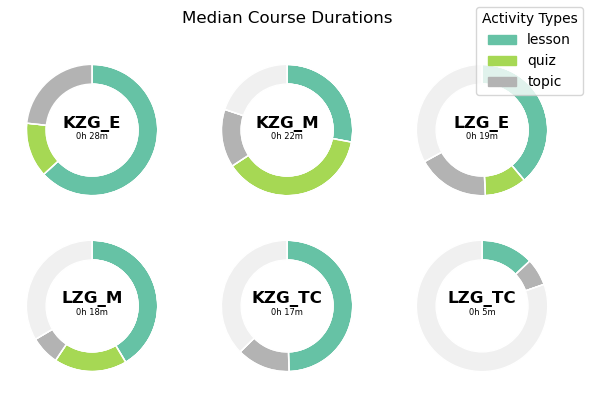

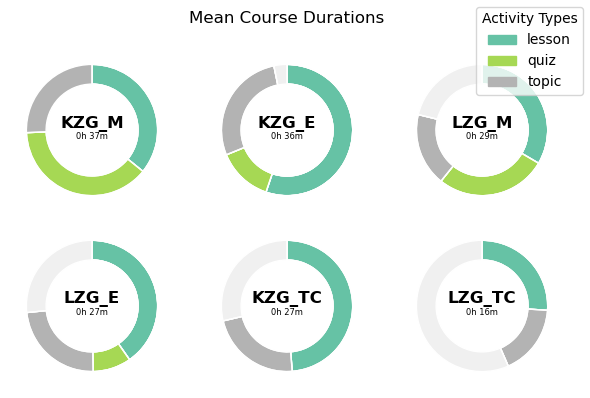

In [ ]:
def plot_course_durations(df_median, course_map_short, title):
    # Prepare the data
    df_median = df_median.copy()
    df_median['duration_sec'] = df_median['duration'].dt.total_seconds()
    
    total_durations = df_median.groupby('course_id')['duration_sec'].sum()
    max_total_duration = total_durations.max()

    # Color map for activities
    activity_types = sorted(df_median['activity_type'].unique())
    cmap = plt.get_cmap('Set2')
    colors = cmap(np.linspace(0, 1, len(activity_types)))
    color_map = dict(zip(activity_types, colors))

    # Plot settings
    courses = total_durations.sort_values(ascending=False).index
    n_courses = len(courses)
    n_cols = 3
    n_rows = int(np.ceil(n_courses / n_cols))
    scale = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale))
    axes = axes.flatten()

    for idx, course_id in enumerate(courses):
        ax = axes[idx]
        course_data = df_median[df_median['course_id'] == course_id]
        durations = course_data['duration_sec'].values
        labels = course_data['activity_type'].values

        total_duration = durations.sum()
        course_fraction = total_duration / max_total_duration
        max_angle = 360 * course_fraction  # Total filled angle for this course

        # Compute sizes in angles instead of fractions of 1
        sizes = durations / total_duration * max_angle

        start_angle = 90
        for label, size in zip(labels, sizes):
            ax.pie(
                [size, 360 - size], 
                colors=[color_map[label], (0, 0, 0, 0)],  # Transparent for remaining part
                startangle=start_angle, 
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )
            start_angle -= size

        # Draw the remaining transparent gap (optional light gray)
        if course_fraction < 1:
            ax.pie(
                [360 * (1 - course_fraction), 360 * course_fraction],
                colors=['#f0f0f0', (0, 0, 0, 0)],
                startangle=90 - max_angle,
                radius=1,
                counterclock=False,
                wedgeprops=dict(width=0.3, edgecolor='white')
            )

        # Add center text
        course_name = course_map_short.get(course_id, course_id)
        total_hours = int(total_duration // 3600)
        total_minutes = int((total_duration % 3600) // 60)
        ax.text(0, 0.1, course_name, ha='center', va='center', fontsize=12, weight='bold')
        ax.text(0, -0.1, f"{total_hours}h {total_minutes}m", ha='center', va='center', fontsize=6)
        
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    # Add Legend
    legend_patches = [mpatches.Patch(color=color_map[act], label=act) for act in activity_types]
    fig.legend(
        handles=legend_patches,
        fontsize=10, 
        loc='upper right', 
        title='Activity Types'
    )
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Median durations
course_median_duration = activities.groupby(['course_id', 'activity_type'])['duration'].median().reset_index()
plot_course_durations(course_median_duration, course_map_short, title="Median Course Durations")

# Mean durations
course_mean_duration = activities.groupby(['course_id', 'activity_type'])['duration'].mean().reset_index()
plot_course_durations(course_mean_duration, course_map_short, title="Mean Course Durations")

### Student Scores (Target):

We use z-scoring on scores per course to obtain normalized scores


In [ ]:
df = all_scores.copy()
df["zscore"] = df.groupby("course")["percentage"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
zscores = df.rename(columns={'course': 'course_id'})
zscores.describe()

,user_id,course_id,percentage,zscore
count,6432.000000,6432.000000,6432.000000,6.432000e+03
mean,2420.168999,2894.153141,56.098510,-1.115747e-16
std,1698.985735,2011.163854,29.366960,1.000078e+00
min,1.000000,42.000000,0.000000,-5.423334e+00
25%,332.000000,42.000000,36.099727,-6.343278e-01
50%,3503.000000,3865.000000,62.500000,2.908645e-02
75%,3932.000000,3865.000000,78.000000,7.789549e-01
max,4095.000000,5447.000000,100.000000,3.370601e+00


### Restrict to Users in the Intersection Only

To ensure consistency, we only retain users who are present in all components:

- `zduration_sum`: Normalized activity durations.
- `gap_days`: Engagement gap lists.
- `user_chains`: Individual Markov Chain objects.
- `zscores`: Target variable for performance.

This ensures that clustering uses complete and coherent feature representations.

In [ ]:
zduration_users = set(zduration_sum['user_id'])
gap_days_users = set(gap_days['user_id'])
user_chains_users = set(user_chains.keys())
zscores_users = set(zscores['user_id'])

# Find the intersection
common_users = zduration_users & gap_days_users & user_chains_users & zscores_users

# Filter each dataframe/dict to only the common users
zduration_sum = zduration_sum[zduration_sum['user_id'].isin(common_users)]
gap_days = gap_days[gap_days['user_id'].isin(common_users)]
user_chains = {k: v for k, v in user_chains.items() if k in common_users}
zscores = zscores[zscores['user_id'].isin(common_users)]

common_users = sorted(common_users)

# Print the number of users in the intersection
print(f'Number of users in all four: {len(common_users)}')

Number of users in all four: 501


### Distance Metric Based on Students' Markov Models

**Approach:**

Let's define a distance between users by comparing their Markov chains. It combines **Jensen-Shannon divergence** over shared states (for transition similarity) and a **penalty** for having different state sets:

$$
\text{Distance} = \alpha \cdot \text{JS} + (1 - \alpha) \cdot \left(1 - \frac{|\text{common states}|}{|\text{all states}|}\right)
$$

In [ ]:
def compute_js_with_penalty(c1, c2, alpha=0.5, pen_multiplier=1):
    """Compute JS divergence + penalty between two Markov chains."""
    
    # Common states between the two chains
    common = list(set(c1.states) & set(c2.states))
    if len(common) < 2:
        return None  # Not enough overlap to compare

    # Indices of common states in each chain
    idx1 = [c1.states.index(s) for s in common]
    idx2 = [c2.states.index(s) for s in common]

    # Submatrices of common states
    P = c1.p[np.ix_(idx1, idx1)]
    Q = c2.p[np.ix_(idx2, idx2)]

    # Average JS divergence for matching rows
    js_vals = []
    for p, q in zip(P, Q):
        if p.sum() > 0 and q.sum() > 0:
            js_vals.append(jensenshannon(p / p.sum(), q / q.sum(), base=2))

    if not js_vals:
        return None

    js = np.mean(js_vals)

    # Penalty for non-overlapping states
    penalty = 1 - len(common) / len(set(c1.states) | set(c2.states))

    # Return weighted sum of JS and penalty
    return alpha * js + (1 - alpha) * penalty * pen_multiplier


def build_distance_matrix(user_chains, alpha=0.5, pen_multiplier=1):
    """Build a distance matrix between users based on their Markov chains."""
    
    users = list(user_chains.keys())

    # Initialize direct distances (0 for same user, inf otherwise)
    direct = { (u,v): (0.0 if u==v else float('inf')) for u in users for v in users }

    # Compute pairwise distances using JS + penalty
    for u1, u2 in combinations(users, 2):
        dist = compute_js_with_penalty(user_chains[u1], user_chains[u2],
                                       alpha=alpha, pen_multiplier=pen_multiplier)
        if dist is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = dist

    # Build graph with finite distances as weighted edges
    G = nx.Graph()
    G.add_nodes_from(users)
    for (u,v), w in direct.items():
        if u != v and w < float('inf'):
            G.add_edge(u, v, weight=w)

    # Compute shortest path distances between all users
    sp_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='weight'))

    # Fill distance matrix using shortest path distances
    D = pd.DataFrame(float('inf'), index=users, columns=users)
    for u in users:
        for v, d in sp_lengths[u].items():
            D.at[u, v] = d

    # Number of connected components in the graph
    n_components = nx.number_connected_components(G)

    return D, n_components

# Compute the distance matrix and number of user groups (connected components)
dist_matrix, components = build_distance_matrix(user_chains, alpha=0.2, pen_multiplier=1)
print("Connected components:", components)

Connected components: 1


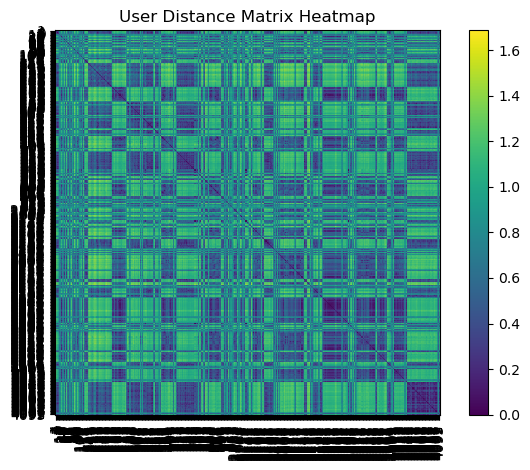

In [ ]:
# Display the distance matrix as Heatmap
fig, ax = plt.subplots()
im = ax.imshow(dist_matrix.values)

# Label axes with user IDs
ax.set_xticks(range(len(dist_matrix.columns)))
ax.set_xticklabels(dist_matrix.columns, rotation=90)
ax.set_yticks(range(len(dist_matrix.index)))
ax.set_yticklabels(dist_matrix.index)

ax.set_title('User Distance Matrix Heatmap')

# Add a colorbar to interpret distances
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

Finally, let's computes a combined distance matrix between users by integrating three distance metrics:

- DTW distance based on users’ activity gap sequences
- Graph-based distance derived from the shortest paths in the Markov-based user graph
- Direct Markov-based distance

In [ ]:
# DTW Distance Matrix based on gap_days
n_users = len(common_users)
graph_matrix = dist_matrix.values
gap_days_map = gap_days.set_index('user_id')['gap_days'].to_dict()
gap_days_seqs = [gap_days_map[u] for u in common_users]
dtw_matrix = np.zeros((n_users, n_users))
for i in range(n_users):
    for j in range(i + 1, n_users):
        d = dtw(gap_days_seqs[i], gap_days_seqs[j])
        dtw_matrix[i, j] = dtw_matrix[j, i] = d

def normalize_matrix(m):
    """Normalize matrix"""
    return (m - np.min(m)) / (np.max(m) - np.min(m))

dtw_norm = normalize_matrix(dtw_matrix)
graph_norm = normalize_matrix(graph_matrix)
combined_matrix = (dtw_norm + 2*dist_matrix + graph_norm) / 4.0

### Visualization Illustrating the Theory Behind the Metric

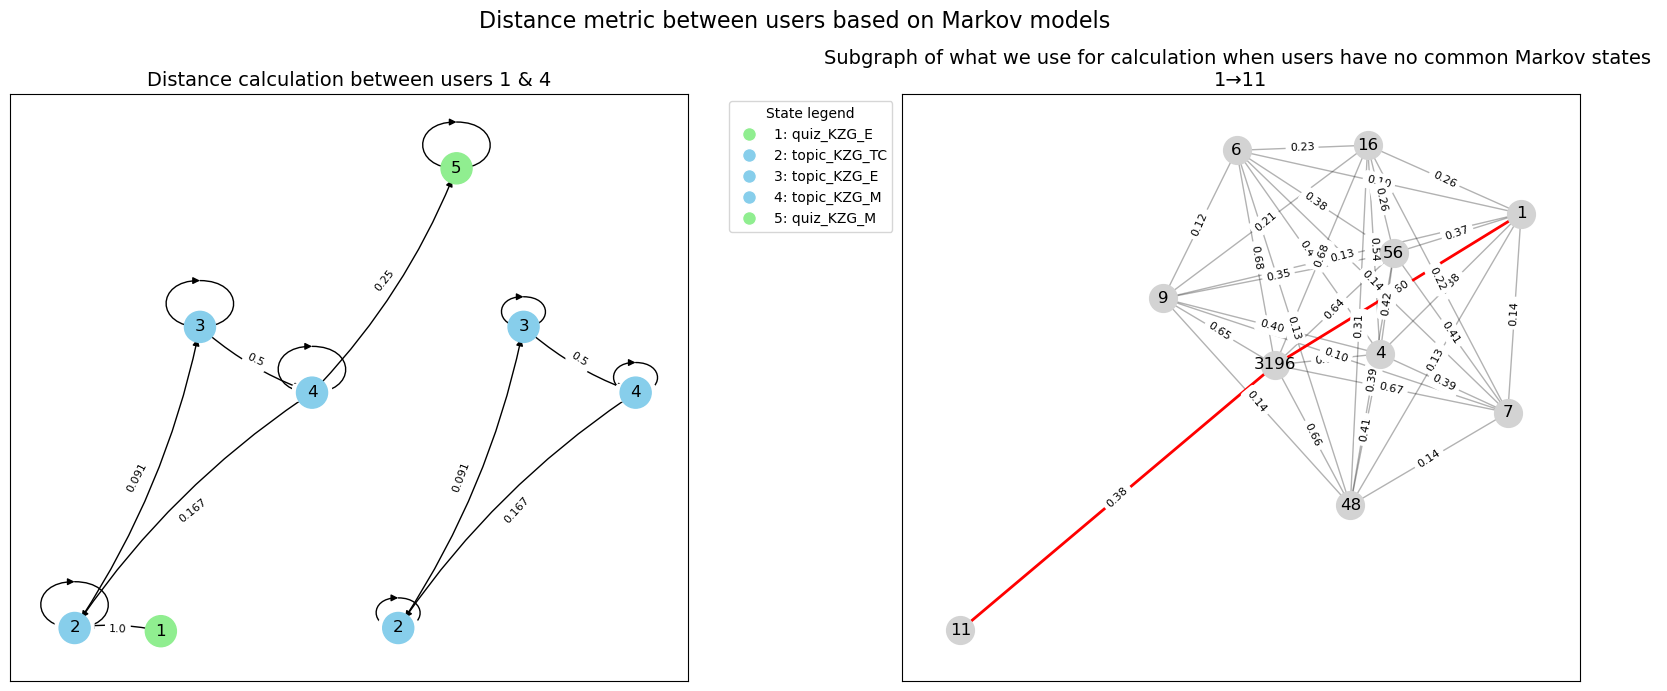

In [ ]:
def build_distance_graph(user_chains, alpha=0.5, pen_multiplier=1):
    """Builds a graph from pairwise distances, skipping pairs with no overlap."""
    users = list(user_chains.keys())
    direct = {(u,v): (0.0 if u == v else float('inf')) for u in users for v in users}

    for u1, u2 in combinations(users, 2):
        dist = compute_js_with_penalty(user_chains[u1], user_chains[u2], alpha=alpha, pen_multiplier=pen_multiplier)
        if dist is not None:
            direct[(u1,u2)] = direct[(u2,u1)] = dist

    G = nx.Graph()
    G.add_nodes_from(users)
    for (u, v), w in direct.items():
        if u != v and w < float('inf'):
            G.add_edge(u, v, weight=w)

    return G, direct

# Helper function
def expand_to_n_nodes(G, core_nodes, n=10):
    included = set(core_nodes)
    queue = list(core_nodes)
    while queue and len(included)<n:
        v = queue.pop(0)
        for nbr in G.neighbors(v):
            if nbr not in included:
                included.add(nbr)
                queue.append(nbr)
                if len(included)>=n:
                    break
    return included

# 
def plot_two_panels(user_chains, alpha=0.2, pen_mult=1):
    """Display two panels as figure"""

    # Pick one pair WITH common states
    users = list(user_chains.keys())
    s1, s2 = next((a,b) for a,b in combinations(users,2) if set(user_chains[a].states) & set(user_chains[b].states))
    c1, c2 = user_chains[s1], user_chains[s2]

    # Build distance graph, pick pair WITHOUT common 
    G, direct = build_distance_graph(user_chains, alpha, pen_mult)
    a,b = next((u,v) for u,v in combinations(users,2) if direct[(u,v)]>=float('inf') and v in nx.node_connected_component(G,u))
    path = nx.shortest_path(G, a, b, weight='weight')

    # 10-node neighborhood around that path
    nodes10 = expand_to_n_nodes(G, path, n=10)
    subG10  = G.subgraph(nodes10).copy()

    # Union graph of the two chains
    H = nx.DiGraph()
    for C in (c1, c2):
        for i,u in enumerate(C.states):
            for j,v in enumerate(C.states):
                if C.p[i,j]>0:
                    H.add_edge(u,v, weight=round(C.p[i,j],3))

    # build a single layout, then split
    pos0 = nx.spring_layout(H, seed=42)
    pos1 = {n:(x*0.4-0.3,y) for n,(x,y) in pos0.items()}
    pos2 = {n:(x*0.4+0.3,y) for n,(x,y) in pos0.items()}

    # Classify states
    common = set(c1.states) & set(c2.states)
    unique = set(c1.states)-common
    def node_color(s):
        if s in common:   return 'skyblue'
        if s in unique:  return 'lightgreen'
        return 'lightcoral'

    # Remap state names -> small ints for left panel
    left_states = list(c1.states) + [s for s in c2.states if s not in c1.states]
    left_states = list(dict.fromkeys(left_states))
    mapping = {state: idx+1 for idx, state in enumerate(left_states)}

    # Display plots
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,7))
    fig.suptitle("Distance metric between users based on Markov models", fontsize=16)

    # Left panel
    for states,pos in [(c1.states,pos1),(c2.states,pos2)]:
        # nodes with numeric labels
        nx.draw_networkx_nodes(H.subgraph(states), pos,
                               node_color=[node_color(s) for s in states],
                               node_size=500, ax=ax1)
        # edges
        nx.draw_networkx_edges(H.subgraph(states), pos,
                               arrows=True, arrowstyle='-|>',
                               ax=ax1, connectionstyle='arc3,rad=0.1')
        # numeric labels
        labels_num = {s: str(mapping[s]) for s in states}
        nx.draw_networkx_labels(H.subgraph(states), pos,
                                labels=labels_num, ax=ax1)
        # edge-labels = transition probs
        edge_lbls = nx.get_edge_attributes(H.subgraph(states),'weight')
        nx.draw_networkx_edge_labels(H.subgraph(states), pos,
                                     edge_labels=edge_lbls,
                                     font_size=8, ax=ax1)

    ax1.set_title(f"Distance calculation between users {s1} & {s2}", fontsize=14)
    # legend at right of left plot
    legend_items = [plt.Line2D([0],[0], marker='o', color='w',
                     label=f"{mapping[state]}: {state}",
                     markerfacecolor=node_color(state), markersize=10)
                    for state in left_states]
    ax1.legend(handles=legend_items, bbox_to_anchor=(1.05,1), loc='upper left', title="State legend")

    # Right panel
    posR = nx.spring_layout(subG10, seed=24)

    # Nodes
    nx.draw_networkx_nodes(subG10, posR, node_color='lightgray', node_size=400, ax=ax2)
    nx.draw_networkx_labels(subG10, posR, ax=ax2)

    # All edges lightly
    nx.draw_networkx_edges(subG10, posR, ax=ax2, alpha=0.3)

    # Highlight the shortest-path edges in red
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(subG10, posR, edgelist=path_edges, edge_color='r', width=2, ax=ax2)

    # Draw edge weight labels on top of edges
    wlabels = nx.get_edge_attributes(subG10, 'weight')
    wlabels_2d = {k: f"{v:.2f}" for k, v in wlabels.items()}
    nx.draw_networkx_edge_labels(subG10, posR, edge_labels=wlabels_2d, font_size=8, ax=ax2)
    ax2.set_title(f"Subgraph of what we use for calculation when users have no common Markov states \n{a}→{b}", fontsize=14)

    plt.tight_layout()
    plt.show()

plot_two_panels(user_chains, alpha=0.2, pen_mult=1)

### Students Clustering

**Approach:**

We will apply two clustering methods: K-Means and Spectral Clustering, and compare their results.

To determine the optimal number of clusters for each method, we will use the silhouette score.


Best Spectral Clustering: 2 clusters (Silhouette = 0.616)
Best KMeans Clustering: 2 clusters (Silhouette = 0.616)


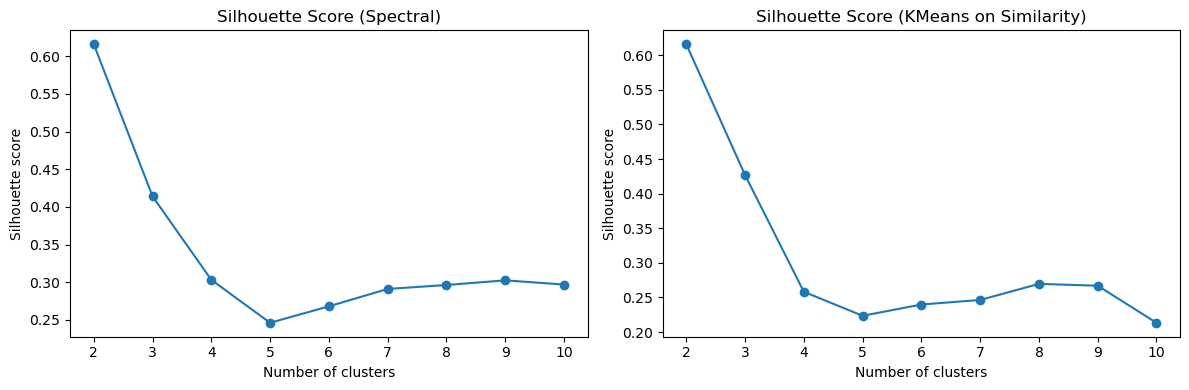

In [ ]:
# Convert distance matrix to similarity matrix
sigma = np.median(combined_matrix)
similarity_matrix = np.exp(-combined_matrix ** 2 / (2.0 * sigma ** 2))

range_n_clusters = range(2, min(11, len(common_users)))

# Initialize tracking variables
results = {
    'Spectral': {'scores': [], 'best_score': -1, 'best_n': None, 'best_labels': None},
    'KMeans': {'scores': [], 'best_score': -1, 'best_n': None, 'best_labels': None}
}

# Run both clustering methods for each k
for n_clusters in range_n_clusters:
    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels_spec = spectral.fit_predict(similarity_matrix)
    score_spec = silhouette_score(combined_matrix, labels_spec, metric='precomputed')
    results['Spectral']['scores'].append(score_spec)
    if score_spec > results['Spectral']['best_score']:
        results['Spectral'].update({'best_score': score_spec, 'best_n': n_clusters, 'best_labels': labels_spec})
    
    # KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels_km = kmeans.fit_predict(similarity_matrix)
    score_km = silhouette_score(combined_matrix, labels_km, metric='precomputed')
    results['KMeans']['scores'].append(score_km)
    if score_km > results['KMeans']['best_score']:
        results['KMeans'].update({'best_score': score_km, 'best_n': n_clusters, 'best_labels': labels_km})

# Print best results
print(f"Best Spectral Clustering: {results['Spectral']['best_n']} clusters (Silhouette = {results['Spectral']['best_score']:.3f})")
print(f"Best KMeans Clustering: {results['KMeans']['best_n']} clusters (Silhouette = {results['KMeans']['best_score']:.3f})")

# Plot both silhouette curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(list(range_n_clusters), results['Spectral']['scores'], marker='o')
axs[0].set_title("Silhouette Score (Spectral)")
axs[0].set_xlabel("Number of clusters")
axs[0].set_ylabel("Silhouette score")

axs[1].plot(list(range_n_clusters), results['KMeans']['scores'], marker='o')
axs[1].set_title("Silhouette Score (KMeans on Similarity)")
axs[1].set_xlabel("Number of clusters")
axs[1].set_ylabel("Silhouette score")

plt.tight_layout()
plt.show()

# Save best labels
labels_spectral = results['Spectral']['best_labels']
labels_kmeans = results['KMeans']['best_labels']

# Cluster information
cluster_df = pd.DataFrame({
    'user_id': common_users,
    'cluster_spectral': labels_spectral,
    'cluster_kmeans': labels_kmeans
})

**Observation:**

Both clustering methods identify an optimal number of clusters at `k = 2`, yielding the same silhouette score of 0.616. However, as `k` increases, the silhouette scores diverge. This suggests that with two clusters, the methods may capture a similar underlying structure, while with more clusters, they begin to detect different patterns. Let's now compare the agreement between the two methods.


In [ ]:
# Compute agreement between Spectral and K-means
ari = adjusted_rand_score(labels_kmeans, labels_spectral)
nmi = normalized_mutual_info_score(labels_kmeans, labels_spectral)

print(f"Adjusted Rand Index (ARI): {ari:.2f}")
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")


Adjusted Rand Index (ARI): 1.00
Normalized Mutual Information (NMI): 1.00


**Observation:**

Both the Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) between K-means and Spectral Clustering cluster assignments are 1.0, indicating perfect agreement between the two methods for this choice of features and cluster number. This strong consistency suggests that the features may capture a robust underlying structure in the data that is recognized by both algorithms.

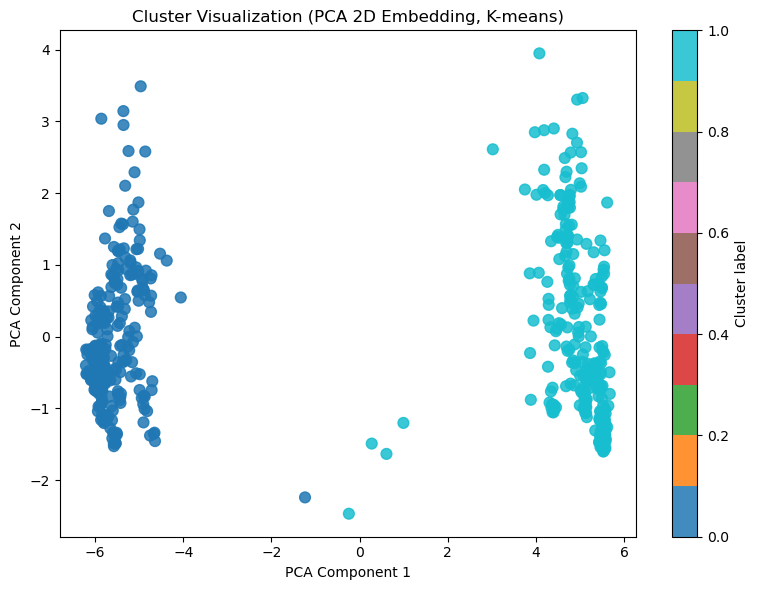

In [ ]:
# PCA projection to 2D
pca = PCA(n_components=2)
coords = pca.fit_transform(combined_matrix)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=labels_kmeans, cmap='tab10', s=60, alpha=0.85)
plt.title('Cluster Visualization (PCA 2D Embedding, K-means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster label')
plt.tight_layout()
plt.show()

**Observation:**

The PCA projection reveals two clearly separated clusters in 2D. Our assumption is the original high-dimensional space, some intra-cluster variability or borderline cases lower the silhouette score.

### Clusters Structural Difference

Now that we have our clusters, let's analyze how students' Markov chain structures differ. For example, whether one cluster has more nodes, edges, or cycles than the other.


In [ ]:
def markov_chain_metrics(chain):
    n_states = len(chain.states)
    n_transitions = np.sum(chain.p > 0)

    # Loop ratio = fraction of states with a self-loop
    self_loops = np.sum(np.diag(chain.p) > 0)
    loop_ratio = self_loops / n_states if n_states > 0 else 0

    # Cycle ratio = fraction of transitions involved in non-trivial cycles
    G = nx.DiGraph()
    for i, u in enumerate(chain.states):
        for j, v in enumerate(chain.states):
            if chain.p[i, j] > 0:
                G.add_edge(u, v)
    cycles = list(nx.simple_cycles(G))
    non_trivial_cycles = [c for c in cycles if len(c) > 1]
    transitions_in_cycles = set()
    for cycle in non_trivial_cycles:
        transitions_in_cycles.update((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle)))
    cycle_ratio = len(transitions_in_cycles) / n_transitions if n_transitions > 0 else 0

    try:
        stat_dist = chain.steady_state_distribution
        stat_entropy = entropy(stat_dist)
    except Exception:
        stat_entropy = np.nan

    return n_states, n_transitions, loop_ratio, cycle_ratio, stat_entropy


metrics = []
for uid in common_users:
    chain = user_chains[uid]
    n_states, n_trans, loop_ratio, cycle_ratio, stat_entropy = markov_chain_metrics(chain)
    metrics.append({
        'user_id': uid,
        'n_states': n_states,
        'n_transitions': n_trans,
        'loop_ratio': loop_ratio,
        'cycle_ratio': cycle_ratio,
        'stat_entropy': stat_entropy,
    })

metrics_df = pd.DataFrame(metrics)
metrics_df['cluster'] = labels_kmeans

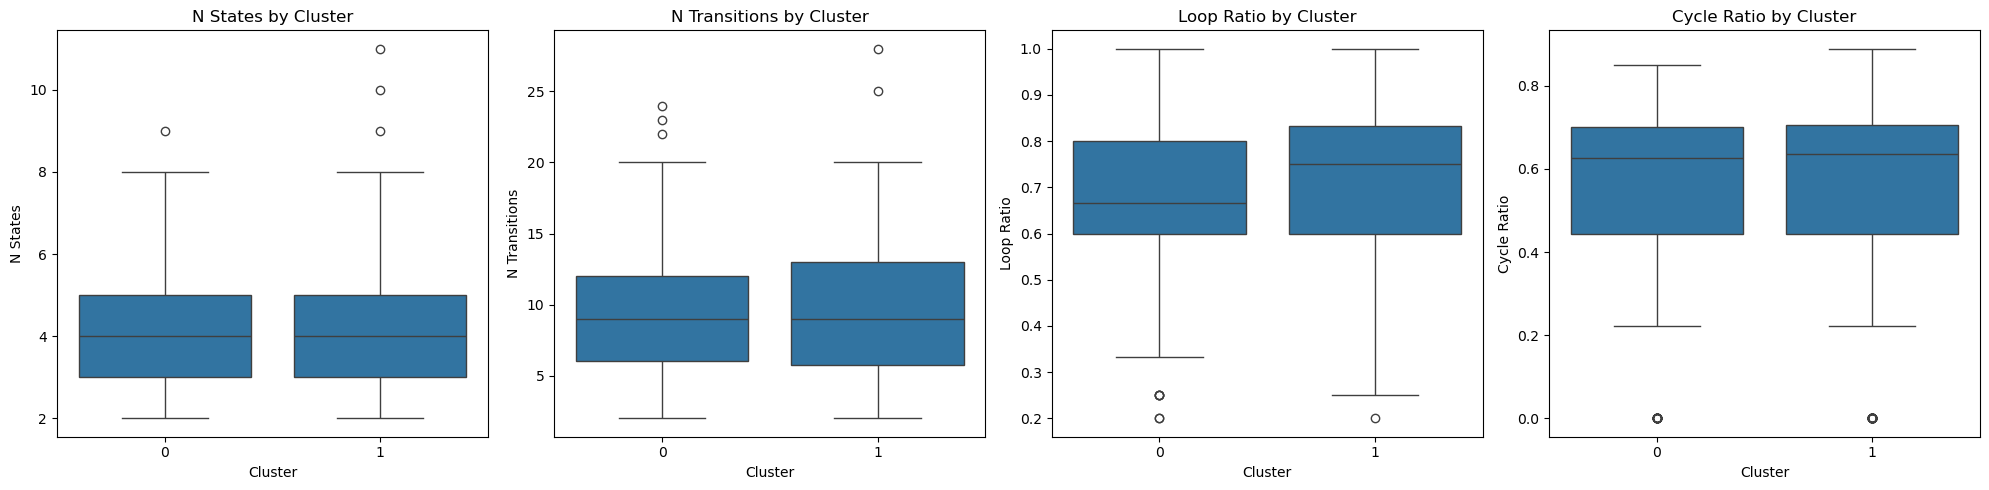

In [ ]:
metrics_to_plot = ['n_states', 'n_transitions', 'loop_ratio', 'cycle_ratio']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, metric in enumerate(metrics_to_plot):
    sns.boxplot(data=metrics_df, x='cluster', y=metric, ax=axes[i])
    axes[i].set_title(f"{metric.replace('_', ' ').title()} by Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(metric.replace('_', ' ').title())

plt.tight_layout()
plt.show()


**Observation:**

We observe more looping behavior in Cluster 1 (loop ratio 0.75 vs 0.67), suggesting a more repetitive learning style.

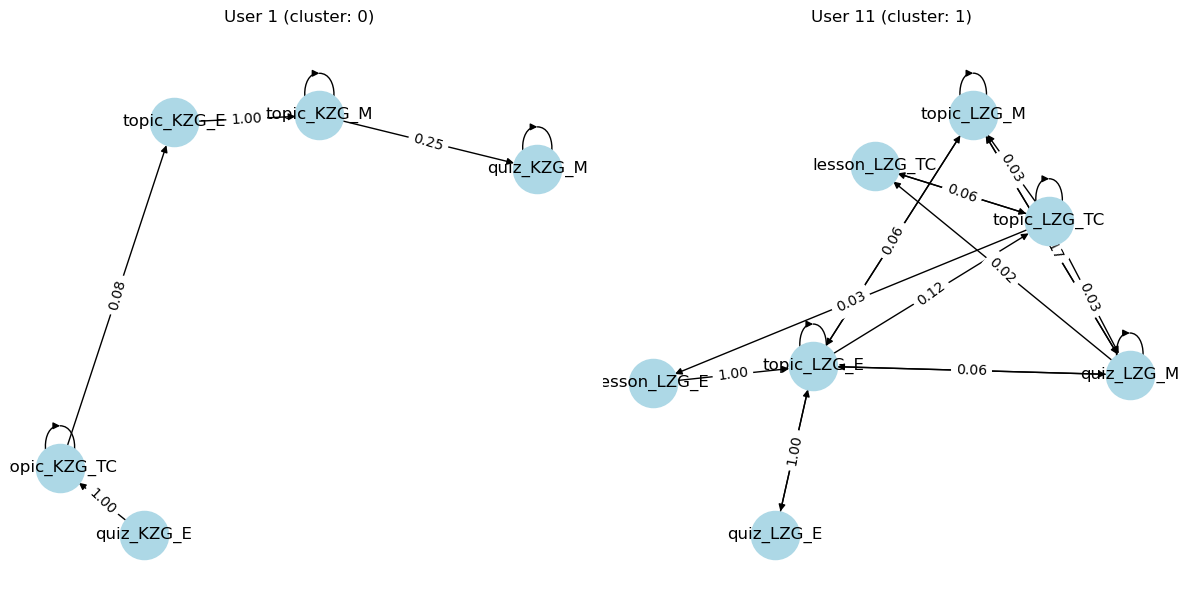

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, clust in enumerate(sorted(metrics_df['cluster'].unique())):
    # Take first user in the cluster
    example_user = metrics_df[metrics_df['cluster'] == clust]['user_id'].iloc[0]
    chain = user_chains[example_user]
    G = nx.DiGraph()
    for i, src in enumerate(chain.states):
        for j, dst in enumerate(chain.states):
            if chain.p[i, j] > 0:
                G.add_edge(src, dst, weight=chain.p[i, j])
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1200, node_color='lightblue', ax=axes[idx])
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()}, ax=axes[idx])
    axes[idx].set_title(f"User {example_user} (cluster: {clust})\n")

plt.tight_layout()
plt.show()


**Observation:**

For a fair comparison, we randomly selected the first student from each cluster. Student 11 from Cluster 1 has a complex Markov chain with many loops, while Student 1 from Cluster 0 follows a simpler, more linear path. This aligns with the overall loop statistics above.

### Comparison and Evaluation of Grades Between Clusters

In [ ]:
number_of_clusters = 2

cluster_users_dict = (
    cluster_df.groupby('cluster_spectral')['user_id']
    .apply(list)
    .to_dict()
)

print("Number of users per cluster: " + ", ".join(f"Cluster {i}: {len(cluster_users_dict[i])}" for i in range(number_of_clusters)))

Number of users per cluster: Cluster 0: 237, Cluster 1: 264


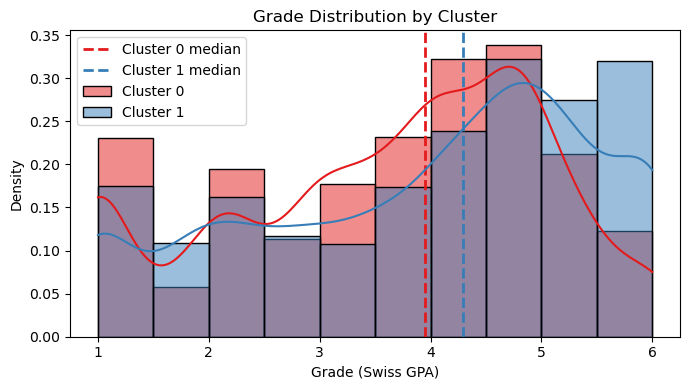

Cluster 0: Mean = 52.34, Median = 59.00
Cluster 1: Mean = 58.77, Median = 65.88


In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

colors = sns.color_palette("Set1", n_colors=number_of_clusters)

for i in range(number_of_clusters):
    cluster_users = cluster_users_dict[i]
    data = zscores[zscores['user_id'].isin(cluster_users)].copy()
    data['gpa'] = data['percentage'].apply(swiss_gpa)
    sns.histplot(
        data=data,
        x='gpa',
        kde=True,
        stat="density",
        bins=10,
        ax=ax,
        color=colors[i],
        label=f'Cluster {i}',
        alpha=0.5
    )
    # Median line
    median_val = data['gpa'].median()
    ax.axvline(median_val, color=colors[i], linestyle='--', linewidth=2, label=f'Cluster {i} median')

ax.set_xlabel('Grade (Swiss GPA)')
ax.set_ylabel('Density')
ax.set_title('Grade Distribution by Cluster')
ax.legend()
plt.tight_layout()
plt.show()

# Average and median score per cluster
for i in range(number_of_clusters):
    users = cluster_users_dict[i]
    cluster_scores = zscores[zscores['user_id'].isin(users)]['percentage']
    print(f"Cluster {i}: Mean = {cluster_scores.mean():.2f}, Median = {cluster_scores.median():.2f}")        

**Observation:**

We observe a substantial difference in grades between the two clusters.
As shown in the figure, **Cluster 1** students tend to have higher grades, with a **mean of 58.77** and a **median of 65.88**, compared to **Cluster 0**, which has a **mean of 52.34** and a **median of 59.00**. The grade distribution of Cluster 1 is shifted to the right, indicating better academic performance overall. The vertical dashed lines further highlight this gap in medians between the two groups.


In [ ]:
# Helper function
def swiss_gpa(val):
    return (val/100)*5 +1

# Compute Swiss GPA for each user in zscores
zscores['gpa'] = zscores['percentage'].apply(swiss_gpa)

# Merge cluster assignments with zscores
user_cluster_map = cluster_df.set_index('user_id')['cluster_spectral']
zscores_with_cluster = zscores[zscores['user_id'].isin(user_cluster_map.index)].copy()
zscores_with_cluster['cluster'] = zscores_with_cluster['user_id'].map(user_cluster_map)

# Get GPA values for each cluster
gpa_by_cluster = [
    zscores_with_cluster[zscores_with_cluster['cluster'] == k]['gpa'].values
    for k in sorted(cluster_df['cluster_spectral'].unique())
]

# Student t-test between the two clusters
t_stat, p_val = ttest_ind(gpa_by_cluster[1], gpa_by_cluster[0])
print(f"Student t-test between clusters: t = {t_stat:.3f}, p = {p_val:.4f}")

Student t-test between clusters: t = 8.366, p = 0.0000


**Observation:**

We observe that the difference in grades between the two clusters is statistically significant (**p = 0.000**), which is consistent with our visual findings.

# Conclusion

We modeled students’ learning paths using Markov chains to capture their transitions between learning activities. Based on this representation, we applied and evaluated two clustering methods to group students according to their behavioral patterns. Both methods produced consistent groupings, with a silhouette score of **0.616** and a mutual agreement score of **1.0**, indicating strong and reliable clustering performance.

To evaluate whether these behavioral clusters were associated with academic outcomes, we compared the GPA distributions of each cluster:

* **Cluster 0**: Mean GPA = 52.34, Median = 59.00
* **Cluster 1**: Mean GPA = 58.77, Median = 65.88

We further evaluated the difference in grades using a Student’s t-test, which confirmed that the difference is **statistically significant** (**t = 8.366, p = 0.0000**). This suggests that the modeled learning behaviors are meaningfully linked to students’ academic performance.

While analyzing the internal patterns of each cluster is challenging due to the complexity of the Markov models, our experiments provided some insights. Specifically, Cluster 0 appears to have simpler transition structures than Cluster 1. Although the average number of states is similar between the two clusters, the **loop ratio**—the proportion of transitions that revisit the same states—is slightly higher in Cluster 1 (**0.65** vs **0.70**).

This could suggest that students who tend to loop back through learning activities may reinforce their understanding more effectively. This interpretation is further supported by user-level examples: **Cluster 1** includes User 11, who exhibits many loops and cycles, while **Cluster 0** includes User 1, who shows a more linear progression with fewer repetitions. These two users were randomly selected (the first student from each cluster) to ensure a fair comparison.

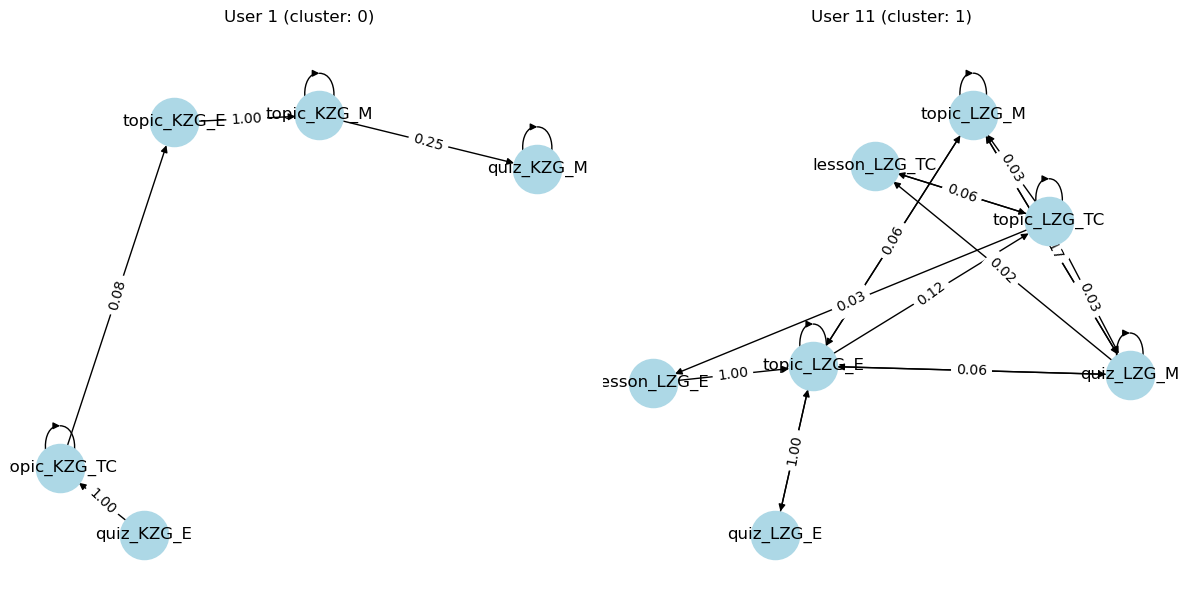

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, clust in enumerate(sorted(metrics_df['cluster'].unique())):
    # Take first user in the cluster
    example_user = metrics_df[metrics_df['cluster'] == clust]['user_id'].iloc[0]
    chain = user_chains[example_user]
    G = nx.DiGraph()
    for i, src in enumerate(chain.states):
        for j, dst in enumerate(chain.states):
            if chain.p[i, j] > 0:
                G.add_edge(src, dst, weight=chain.p[i, j])
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1200, node_color='lightblue', ax=axes[idx])
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()}, ax=axes[idx])
    axes[idx].set_title(f"User {example_user} (cluster: {clust})\n")

plt.tight_layout()
plt.show()


**Observation:**

For a fair comparison, we randomly selected the first student from each cluster. Student 11 from Cluster 1 has a complex Markov chain with many loops, while Student 1 from Cluster 0 follows a simpler, more linear path. This aligns with the overall loop statistics above.

### Comparison and Evaluation of Grades Between Clusters

In [ ]:
number_of_clusters = 2

cluster_users_dict = (
    cluster_df.groupby('cluster_spectral')['user_id']
    .apply(list)
    .to_dict()
)

print("Number of users per cluster: " + ", ".join(f"Cluster {i}: {len(cluster_users_dict[i])}" for i in range(number_of_clusters)))

Number of users per cluster: Cluster 0: 237, Cluster 1: 264


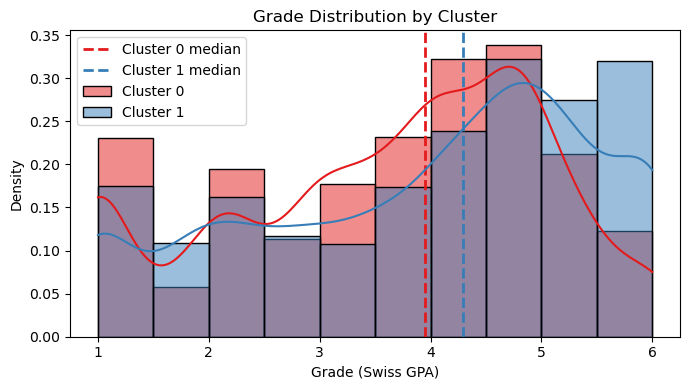

Cluster 0: Mean = 52.34, Median = 59.00
Cluster 1: Mean = 58.77, Median = 65.88


In [26]:
fig, ax = plt.subplots(figsize=(7, 4))

colors = sns.color_palette("Set1", n_colors=number_of_clusters)

for i in range(number_of_clusters):
    cluster_users = cluster_users_dict[i]
    data = zscores[zscores['user_id'].isin(cluster_users)].copy()
    data['gpa'] = data['percentage'].apply(swiss_gpa)
    sns.histplot(
        data=data,
        x='gpa',
        kde=True,
        stat="density",
        bins=10,
        ax=ax,
        color=colors[i],
        label=f'Cluster {i}',
        alpha=0.5
    )
    # Median line
    median_val = data['gpa'].median()
    ax.axvline(median_val, color=colors[i], linestyle='--', linewidth=2, label=f'Cluster {i} median')

ax.set_xlabel('Grade (Swiss GPA)')
ax.set_ylabel('Density')
ax.set_title('Grade Distribution by Cluster')
ax.legend()
plt.tight_layout()
plt.show()

# Average and median score per cluster
for i in range(number_of_clusters):
    users = cluster_users_dict[i]
    cluster_scores = zscores[zscores['user_id'].isin(users)]['percentage']
    print(f"Cluster {i}: Mean = {cluster_scores.mean():.2f}, Median = {cluster_scores.median():.2f}")        

**Observation:**

We observe a substantial difference in grades between the two clusters.
As shown in the figure, **Cluster 1** students tend to have higher grades, with a **mean of 58.77** and a **median of 65.88**, compared to **Cluster 0**, which has a **mean of 52.34** and a **median of 59.00**. The grade distribution of Cluster 1 is shifted to the right, indicating better academic performance overall. The vertical dashed lines further highlight this gap in medians between the two groups.


In [ ]:
# Helper function
def swiss_gpa(val):
    return (val/100)*5 +1

# Compute Swiss GPA for each user in zscores
zscores['gpa'] = zscores['percentage'].apply(swiss_gpa)

# Merge cluster assignments with zscores
user_cluster_map = cluster_df.set_index('user_id')['cluster_spectral']
zscores_with_cluster = zscores[zscores['user_id'].isin(user_cluster_map.index)].copy()
zscores_with_cluster['cluster'] = zscores_with_cluster['user_id'].map(user_cluster_map)

# Get GPA values for each cluster
gpa_by_cluster = [
    zscores_with_cluster[zscores_with_cluster['cluster'] == k]['gpa'].values
    for k in sorted(cluster_df['cluster_spectral'].unique())
]

# Student t-test between the two clusters
t_stat, p_val = ttest_ind(gpa_by_cluster[1], gpa_by_cluster[0])
print(f"Student t-test between clusters: t = {t_stat:.3f}, p = {p_val:.4f}")

Student t-test between clusters: t = 8.366, p = 0.0000


**Observation:**

We observe that the difference in grades between the two clusters is statistically significant (**p = 0.000**), which is consistent with our visual findings.

# Conclusion

We modeled students’ learning paths using Markov chains to capture their transitions between learning activities. Based on this representation, we applied and evaluated two clustering methods to group students according to their behavioral patterns. Both methods produced consistent groupings, with a silhouette score of **0.616** and a mutual agreement score of **1.0**, indicating strong and reliable clustering performance.

To evaluate whether these behavioral clusters were associated with academic outcomes, we compared the GPA distributions of each cluster:

* **Cluster 0**: Mean GPA = 52.34, Median = 59.00
* **Cluster 1**: Mean GPA = 58.77, Median = 65.88

We further evaluated the difference in grades using a Student’s t-test, which confirmed that the difference is **statistically significant** (**t = 8.366, p = 0.0000**). This suggests that the modeled learning behaviors are meaningfully linked to students’ academic performance.

While analyzing the internal patterns of each cluster is challenging due to the complexity of the Markov models, our experiments provided some insights. Specifically, Cluster 0 appears to have simpler transition structures than Cluster 1. Although the average number of states is similar between the two clusters, the **loop ratio**—the proportion of transitions that revisit the same states—is slightly higher in Cluster 1 (**0.65** vs **0.70**).

This could suggest that students who tend to loop back through learning activities may reinforce their understanding more effectively. This interpretation is further supported by user-level examples: **Cluster 1** includes User 11, who exhibits many loops and cycles, while **Cluster 0** includes User 1, who shows a more linear progression with fewer repetitions. These two users were randomly selected (the first student from each cluster) to ensure a fair comparison.